# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can we predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? We will predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



# Import packages

We will be using the following packages in our project

In [146]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from mlxtend.classifier import StackingClassifier
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import my_functions as mf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

#### Import Data

In [2]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [3]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

In [4]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [5]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Processing Well Data for Geospacial Visualization

In [6]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]


test_df_loc = unlabeled_df[['longitude', 'latitude']]
test_df_loc = test_df_loc[test_df_loc['longitude']!=0]
test_df_loc['status_group'] = 'unknown'

#### Import shape files for Tanzania

These shapefiles were found through an online search. Uncomment to directly download and unzip the data to you notebook.

In [7]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [8]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames to Plot in GeoPandas from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [9]:
# Read in our shape file as a GeoDataFrame
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
# Convert crs from 4326 to 3857 
geo_df = geo_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
# Back to our Well Data
# Add a geometry column that holds Point objects with lat and long for our training set
# Initialize crs to 4326 and convert crs from 4326 to 3857 
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
# Add a geometry column that holds Point objects with lat and long for our test set
# Initialize crs to 4326 and convert crs from 4326 to 3857 
test_df_loc['geometry'] = test_df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf_test = gpd.GeoDataFrame(test_df_loc, geometry='geometry')
gdf_test.crs = "EPSG:4326"
gdf_test = gdf_test.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Create an Interactive Folium map to show where Tanzania is

In [12]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 4)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

We will use static GeoPandas plots with Contextily to be able to visually show large datasets.

Map of Africa with Tanzania Highlighted

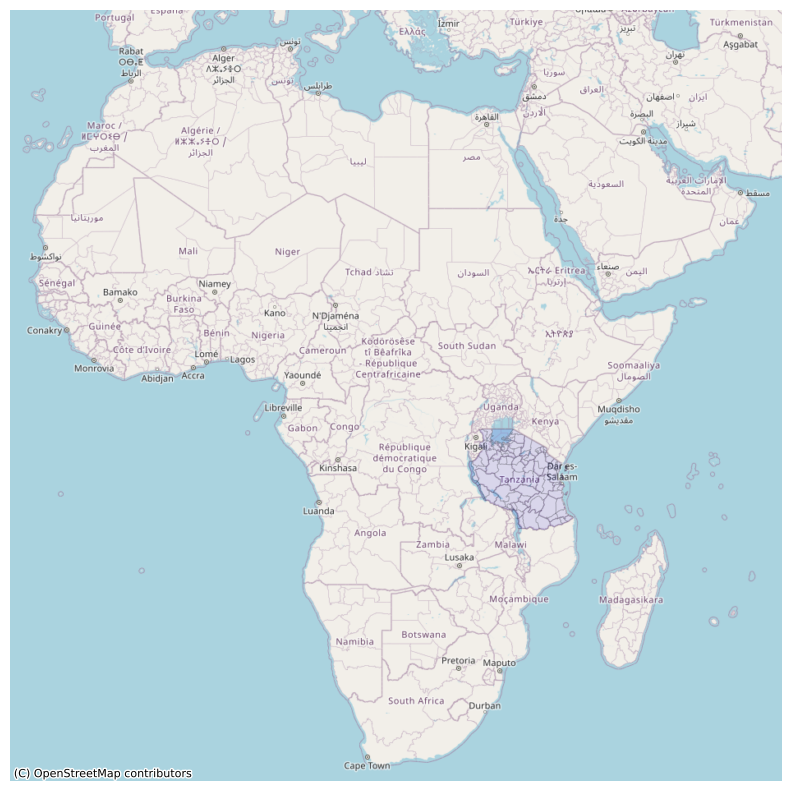

In [13]:
plt.style.use('default')
sns.set_context("paper", font_scale=1)

fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) 
#source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzanian Water Wells')

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Africa.jpg');

#### Zoomed in Map of Tanzania

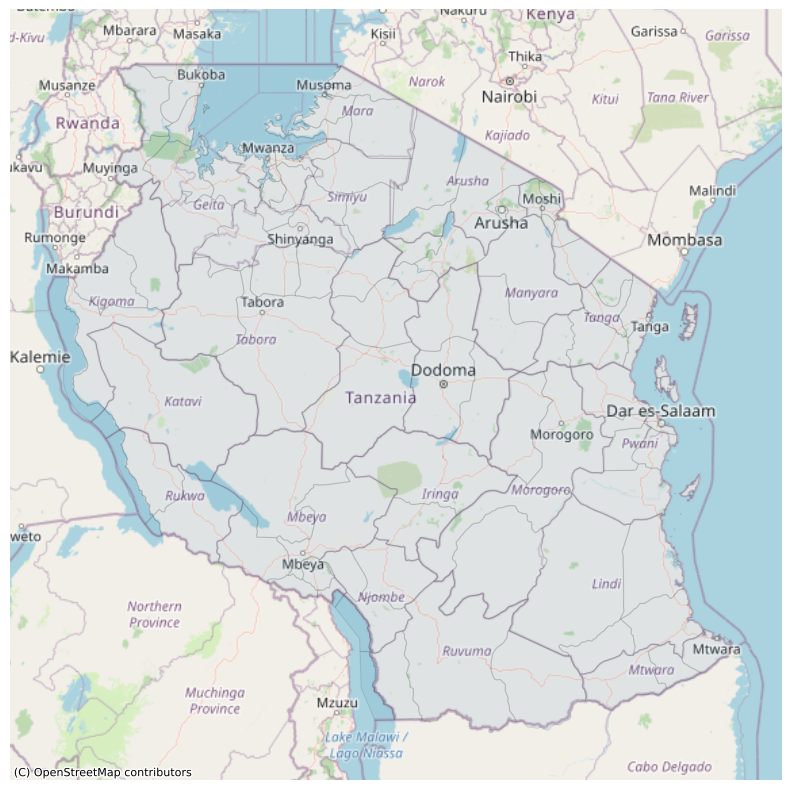

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzania', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania.jpg');

#### Add Wells + Status to Plot

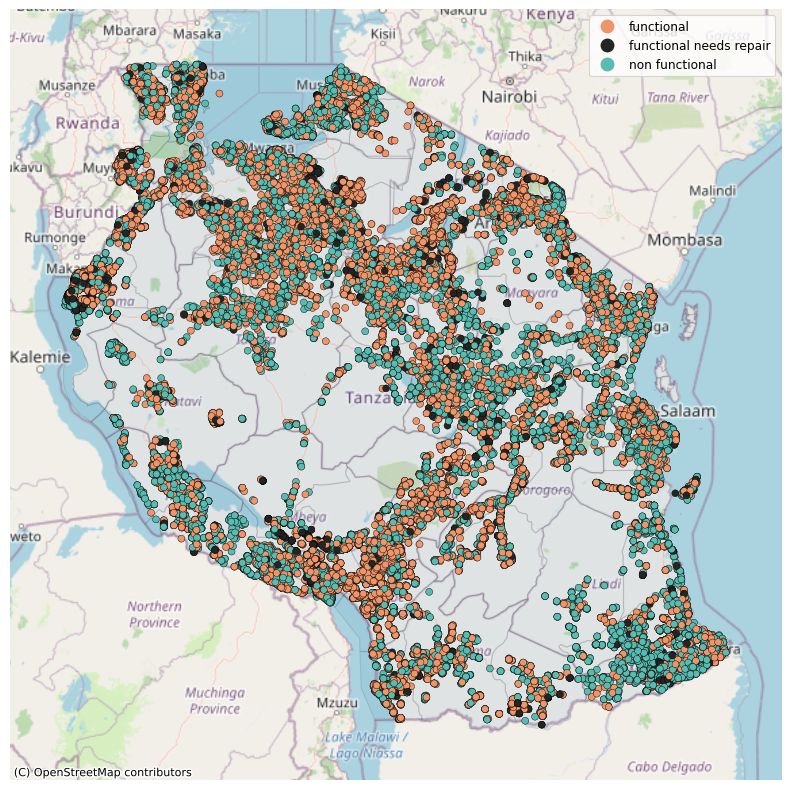

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

custom_palette = sns.diverging_palette(30, 180, l=70, center="dark", as_cmap=True)

# sns.color_palette(palette=[], n_colors=None, desat=None, as_cmap=False)

gdf.plot(ax=ax, column = 'status_group', marker = '.', markersize=100,
         edgecolor = 'black', cmap = custom_palette,
         linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_train.jpg', dpi = 300);

#### Plot the Test Data for wich the Status Classes are Unkown

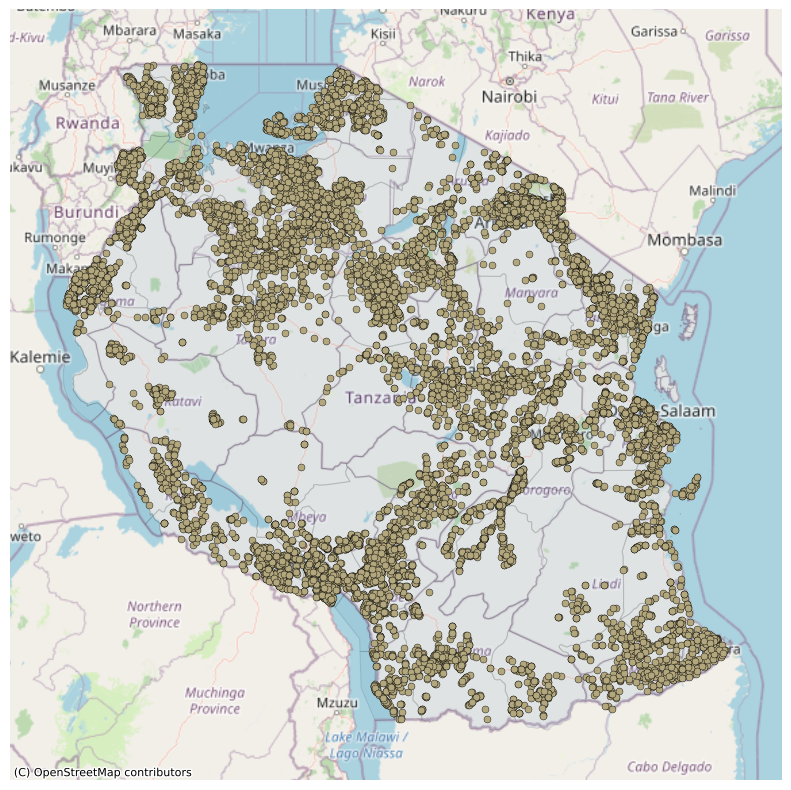

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

gdf_test.plot(ax=ax, marker = '.', markersize=100, color='#B3A77D',
              edgecolor = 'black', linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_test.jpg');

### Data Cleaning

#### Drop the columns that have too many unique categories and/or missing values

In [17]:
# X.info()

In [18]:
columns_with_na = ['permit', 'scheme_name', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [19]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [20]:
X.drop('date_recorded', axis=1, inplace=True)

#### Impute scheme_management Feature NAs with "unknown"
We have determined scheme_management could be statistically significant in our model so we don't want to drop it just because it has null values

In [21]:
X['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [22]:
X['scheme_management'] = X['scheme_management'].fillna("UNKNOWN")

### EDA Visuals

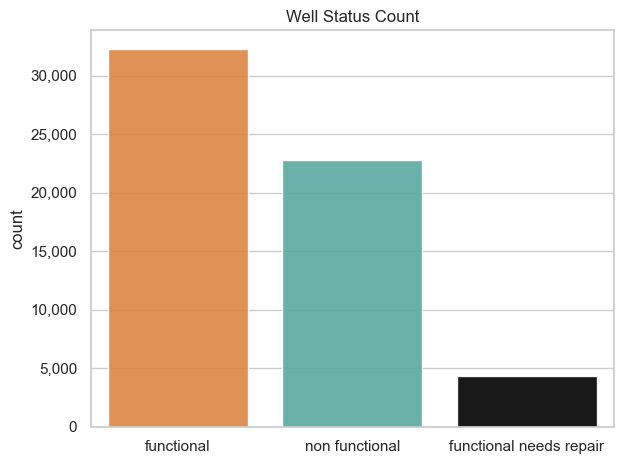

In [148]:
# Set Plot Style
plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

#Create custom color palette
colors = ["#F48328", "#4DB6AC", "black"]
my_palette = sns.color_palette(colors)

#Make plot
fig, ax = plt.subplots() 
sns.countplot(x = y, palette=my_palette, alpha=.9)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(xlabel=None, title = "Well Status Count")
fig.tight_layout()
plt.savefig('../../reports/figures/Well_status_dist.jpg')

In [149]:
dv = X.copy()
dv['target'] = y.copy()

(0.0, 12000.0)

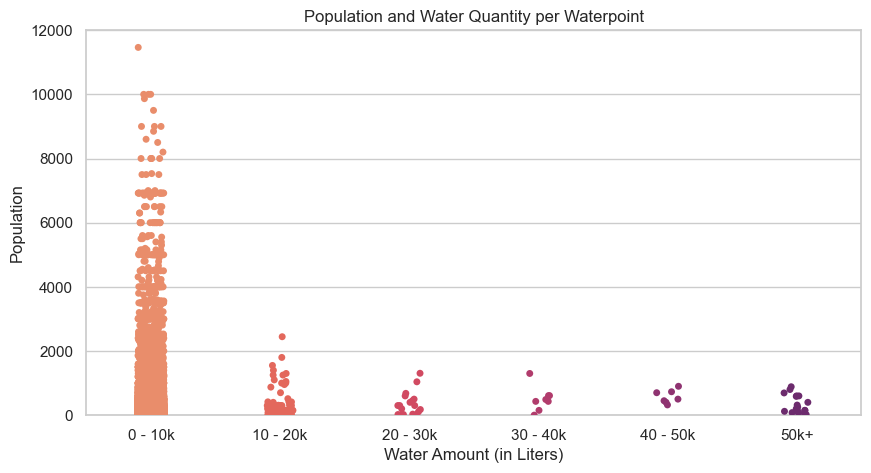

In [150]:
dv['amount'] = dv['amount_tsh'].map(mf.mapp)

sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.figure(figsize = (10,5))
ax = sns.stripplot( x = 'amount', y = 'population', data = dv, palette = 'flare', order = ['0 - 10k', '10 - 20k', '20 - 30k', '30 - 40k', '40 - 50k', '50k+'])
ax.set(xlabel = 'Water Amount (in Liters)', ylabel = 'Population', title = 'Population and Water Quantity per Waterpoint')
plt.ylim(0,12000)


(1960.0, 2020.1)

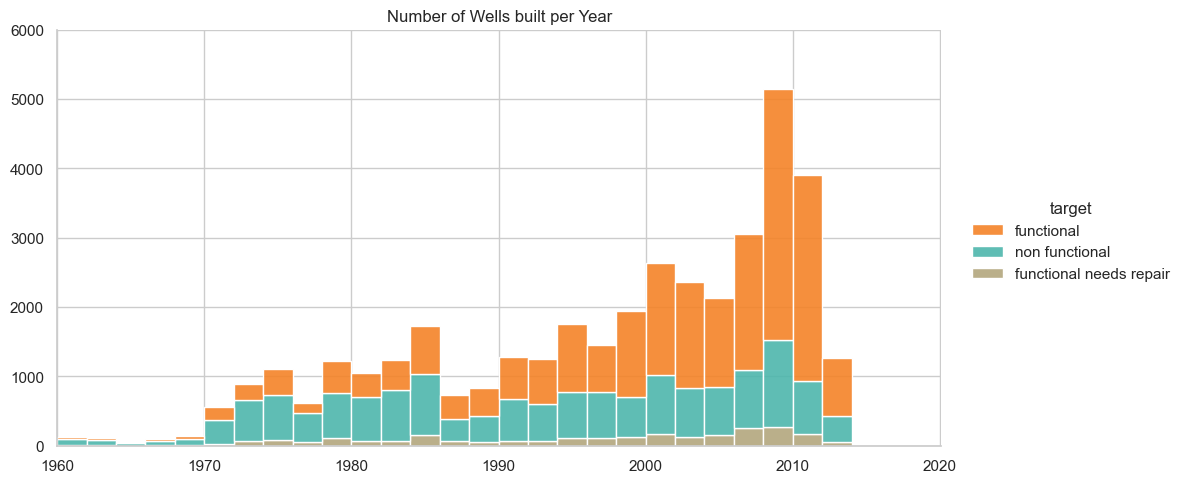

In [26]:
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
count = dv[dv.construction_year != 0]
ax = sns.displot(data = count, x = 'construction_year', kind = 'hist', stat = 'count', hue = 'target', multiple = 'stack', binwidth = 2, element = 'bars', kde = False, legend = True, palette = ['#f48328', '#4db6ac', '#b3a77d'], alpha = 0.9, aspect = 2)
ax.set(xlabel = '', ylabel = '', title = 'Number of Wells built per Year')
legend_labels = ['Functional', 'Non Functional', 'Functional needs Repair']
plt.ylim(0,6000)
plt.xlim(1960, 2020.1)


Text(0.5, 1.0, 'Number of each Pump Type')

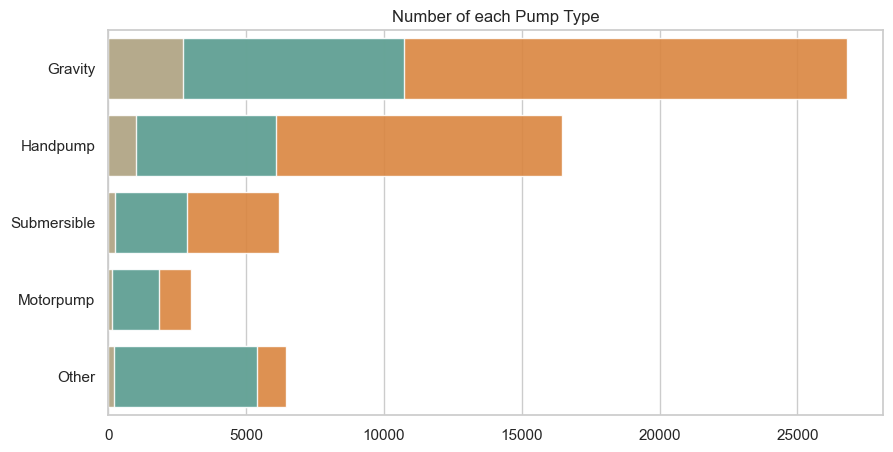

In [27]:
count_rfun = dv[dv['target'] == 'functional needs repair']['extraction_type_class']
count_nfun = pd.concat([dv[dv['target'] == 'non functional']['extraction_type_class'], count_rfun])
count_fun = pd.concat([dv[dv['target'] == 'functional']['extraction_type_class'], count_nfun])

sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
plt.figure(figsize = (10,5))
order = ['gravity', 'handpump', 'submersible', 'motorpump', 'other',]
colors = ['#f48225', '#4eb4ac', '#c7ad82']
xlabel = ''
ylabel = ''
yticks = ['Gravity', 'Handpump', 'Submersible', 'Motorpump', 'Other']
sns.countplot(y = count_fun, orient = 'v', color = colors[0], order = order, alpha = 0.9)
sns.countplot(y = count_nfun, orient = 'v', color = colors[1], order = order, alpha = 0.9)
ax = sns.countplot(y = count_rfun, orient = 'v', color = colors[2], order = order, alpha = 0.9)
ax.set(xlabel = xlabel, ylabel = ylabel, yticklabels = yticks)
ax.set_title('Number of each Pump Type')

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\seaborn\axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


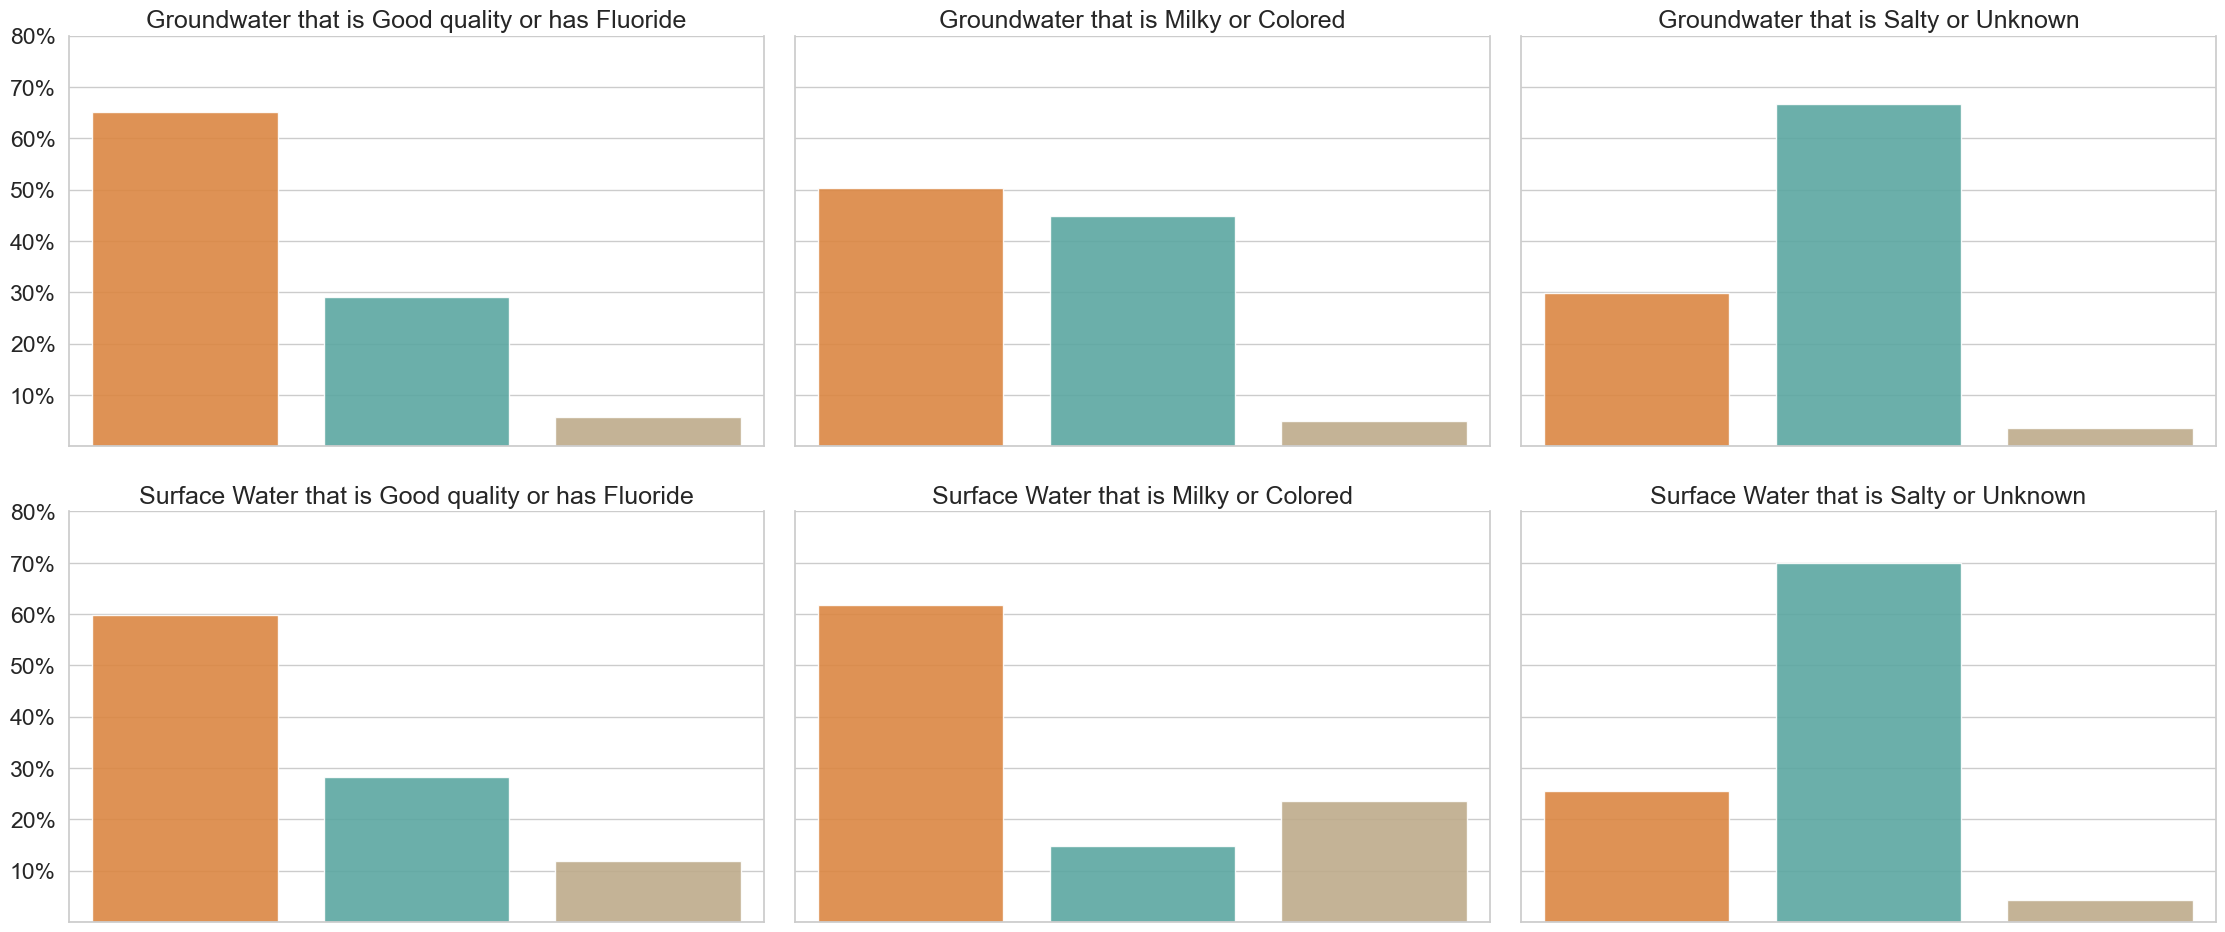

In [28]:
percents = []
cats = dv[dv['source_class'] != 'unknown']
q_0 = ['good', 'fluoride']
q_1 = ['milky', 'colored']
q_2 = ['salty', 'unknown']
for i in cats['source_class'].unique():
    for j in cats['quality_group'].unique():
        tmp = cats[(cats['source_class'] == i) & (cats['quality_group'] == j)]
        percent_sum = tmp.target.value_counts().sort_index().values.sum()
        percent_name = tmp.target.value_counts().sort_index()
        percent = tmp.target.value_counts().sort_index().values/ percent_sum
        if (len(percent) < 3):
            percent = np.concatenate((percent, [0]))
        percents.append([i,j, 'functional', percent[0]])
        percents.append([i,j, 'non functional', percent[2]])
        percents.append([i,j, 'functional needs repair', percent[1]])
        
pf = pd.DataFrame(percents, columns = ['Source', 'quality_group', 'target', 'Percentage'])
pf['Source'] = pf['Source'].str.capitalize()
pf['Source'].replace('Surface', 'Surface Water', inplace = True)
pf.loc[(pf['quality_group'] == q_0[0]) | (pf['quality_group'] == q_0[1]), 'Quality'] = f'{q_0[0].capitalize()} quality or has {q_0[1].capitalize()}'
pf.loc[(pf['quality_group'] == q_1[0]) | (pf['quality_group'] == q_1[1]), 'Quality'] = f'{q_1[0].capitalize()} or {q_1[1].capitalize()}'
pf.loc[(pf['quality_group'] == q_2[0]) | (pf['quality_group'] == q_2[1]), 'Quality'] = f'{q_2[0].capitalize()} or {q_2[1].capitalize()}'

sns.set(context = 'notebook', style = 'whitegrid', font_scale=1.5)
colors = ['#f48328', '#4eb4ac', '#c7ad82']
xlabel = ''
ylabel = ''
xticks = ''
yticks = ['', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%']
ax = sns.catplot(data = pf, x = 'target', y = 'Percentage', kind = 'bar', row = 'Source', col = 'Quality', ci = None, palette = colors, alpha = 0.9, height = 5, aspect = 1.5)
ax.set(xticklabels = xticks, yticklabels = yticks, xlabel = xlabel, ylabel = ylabel, ylim = (0, 0.8))
ax.despine(top = True, left = False, right = False)
ax.set_titles("{row_name} that is {col_name}")

## Preprocess Data for Model

#### Train Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Functions to impute, scale and onehotencode

In [30]:
# Fuction takes in X_train and performs Simple Imputer, Standard Scaler, and OneHotEncoding Fit and Tranforms Data
X_train_fin, si, ss, ohe = mf.preprocess_training_data(X_train)

In [31]:
# Fuction takes in X_test, and fitted Simple Imputer , Standard Scaler, and OneHotEncoding Objects and Transforms Data
X_test_fin = mf.preprocess_testing_data(X_test, si, ss, ohe)

In [32]:
print('Features Count: ', X_train_fin.shape[1])

Features Count:  304


## First Simple Model

#### Logistic Regression

In [33]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Score model on training data

In [34]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.56      0.12      0.20      3243
         non functional       0.80      0.66      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



#### Score model on testing data

In [35]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.20      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



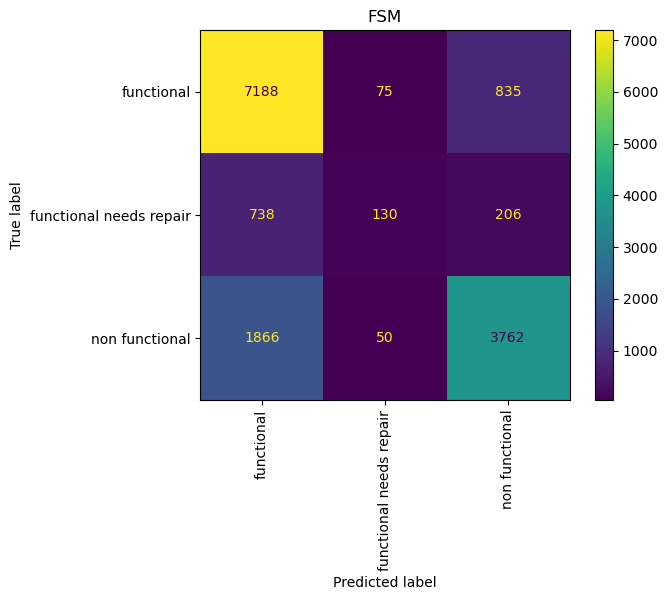

In [36]:
plt.style.use('default')
plot_confusion_matrix(lr, X_test_fin, y_test)
plt.title('FSM')
plt.xticks(rotation='vertical');

<img src = '../../reports/figures/legend_models.png' alt = 'legend_models' width = '200'>

<Figure size 1000x500 with 0 Axes>

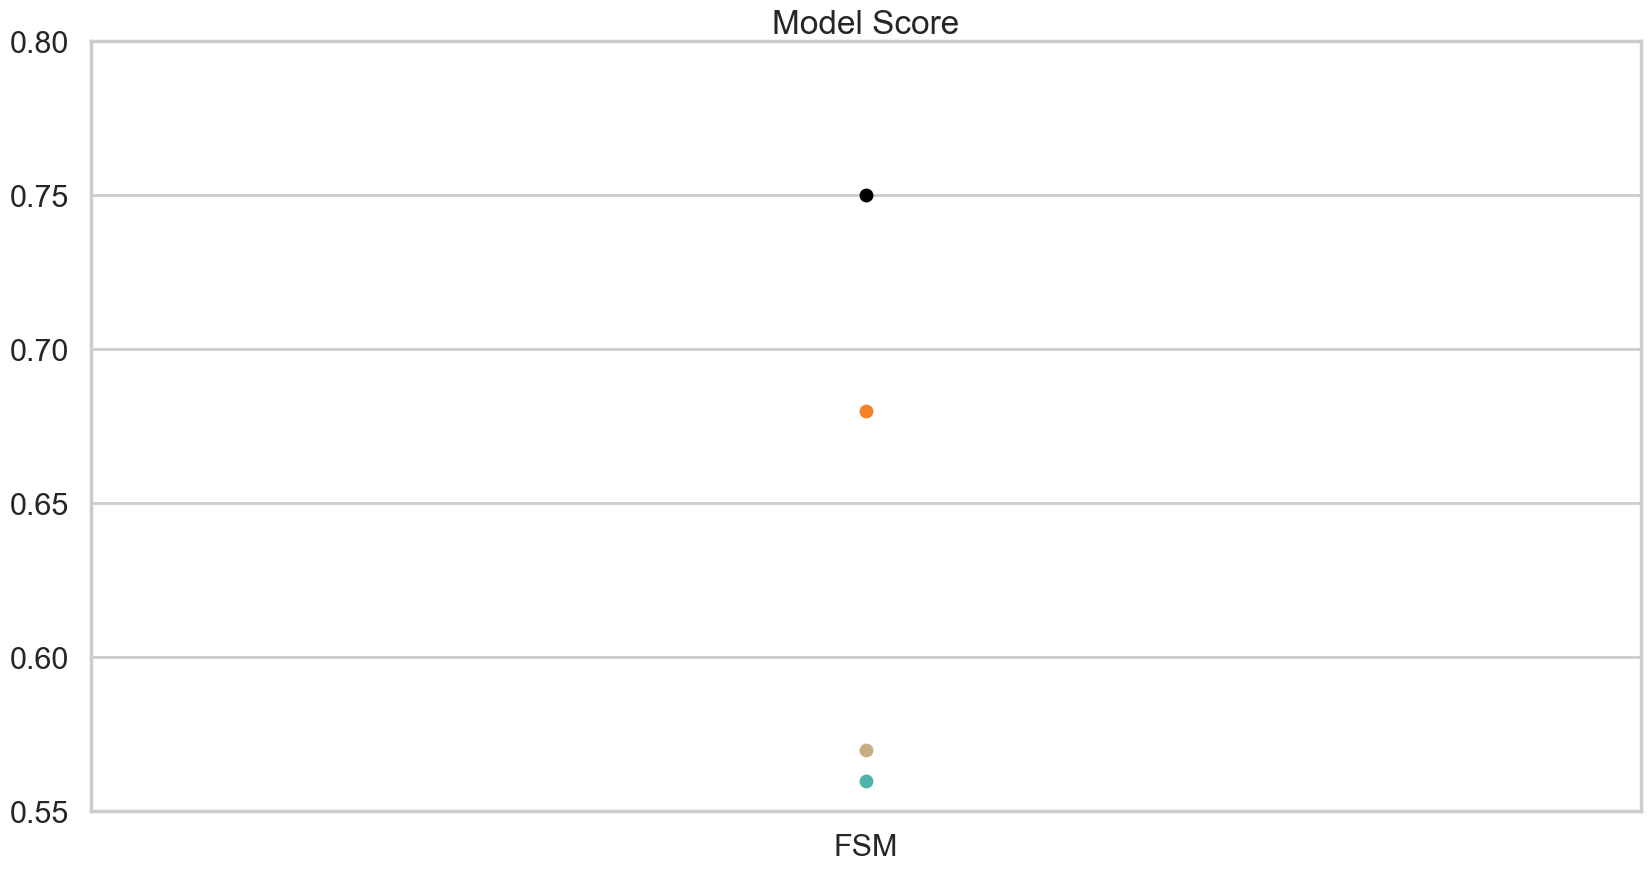

True

In [37]:
mf.plot_model_score(1)

We can see that even though our accuracy was 75%, we are severely underpredicting the class "functional needs repair". Our f1 and recall scores are low. We need to improve upon this. Recall is important to us for the project because it tells us if we have too many false negatives. In other words, we dont want to accidently predict an nonfunctional well as functional.

#### Coefficients of Features To explore Statistically Significant Features

In [38]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [39]:
coef.head(10)

0         1         2
amount_tsh         0.047915  0.018301 -0.066215
gps_height         0.027462  0.203560 -0.231022
longitude         -0.016757  0.034193 -0.017436
latitude          -0.138000  0.251070 -0.113071
num_private       -0.010930  0.015124 -0.004193
region_code       -0.082962  0.069259  0.013704
district_code      0.083414 -0.112323  0.028909
population         0.043173  0.029189 -0.072361
construction_year  0.031810 -0.089394  0.057584
basin_Internal     0.079485  0.039993 -0.119477

## Refining our Data (More Preproccesing)

#### Using Smote to Deal with Class Imbalance

In [40]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 304)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


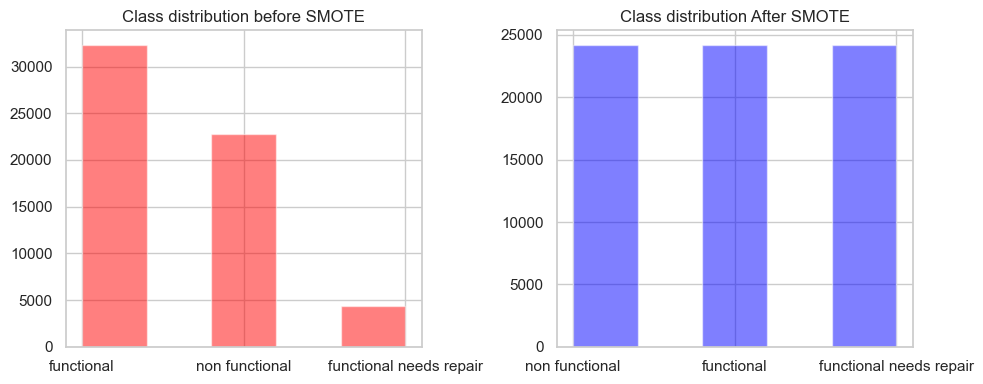

In [41]:
sns.set(context = 'notebook', style = 'whitegrid')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout()
plt.savefig('../../reports/figures/Fixing_class_imbalance.jpg', bbox_inches='tight');

#### Model After Smote

In [42]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [43]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.71     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [44]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.71      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.76      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes. The f1-score and recall scores really improved. Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Dealing with Multicollinearity
Some investigators use correlation coefficients cutoffs of 0.5 and above but most typical cutoff is 0.80

In [45]:
# heheX_train_res, y_train_res, X_test_fin, y_test

In [46]:
print("Top Absolute Correlations")
print(mf.get_top_abs_correlations(X_train_res, 50))

Top Absolute Correlations
extraction_type_mono                extraction_type_group_mono               1.000000
extraction_type_other               extraction_type_class_other              1.000000
quantity_unknown                    quantity_group_unknown                   1.000000
extraction_type_nira/tanira         extraction_type_group_nira/tanira        1.000000
waterpoint_type_hand pump           waterpoint_type_group_hand pump          1.000000
waterpoint_type_cattle trough       waterpoint_type_group_cattle trough      1.000000
extraction_type_other - rope pump   extraction_type_group_rope pump          1.000000
extraction_type_group_gravity       extraction_type_class_gravity            1.000000
source_type_other                   source_class_unknown                     1.000000
water_quality_milky                 quality_group_milky                      1.000000
source_rainwater harvesting         source_type_rainwater harvesting         1.000000
payment_never pay           

In [47]:
top_corrs = mf.get_top_abs_correlations(X_train_res, 47) #Dropping columns with correlation of 1

In [48]:
features_to_drop = [pair[1] for pair in top_corrs.index]

In [49]:
# Remove Duplicates from list
features_to_drop = list(dict.fromkeys(features_to_drop))

In [50]:
X_train_res.drop(features_to_drop, axis=1, inplace=True)

In [51]:
X_test_fin.drop(features_to_drop, axis=1, inplace=True)

#### Feature Selection

In [52]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

ExtraTreesClassifier()

In [53]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = True)
feature_importance_df.head(10)

0
recorded_by_GeoData Consultants Ltd        0.000000e+00
scheme_management_None                     1.269619e-07
waterpoint_type_dam                        6.301087e-06
lga_Lindi Urban                            8.399105e-06
extraction_type_other - mkulima/shinyanga  9.181862e-06
lga_Nyamagana                              2.125332e-05
extraction_type_climax                     3.538498e-05
water_quality_fluoride abandoned           4.934152e-05
management_other - school                  6.169805e-05
scheme_management_SWC                      7.150119e-05

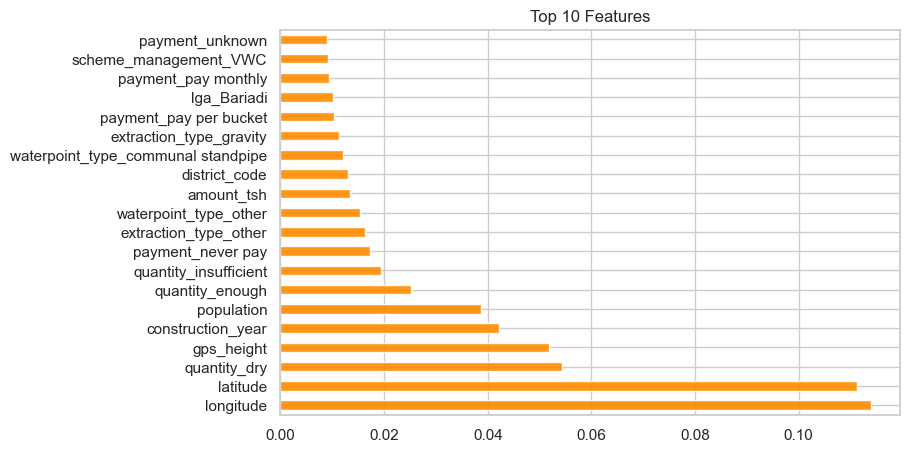

In [54]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig, ax = plt.subplots(figsize = (8,5))
feat_importances.nlargest(20).plot(kind='barh', color = "darkorange", alpha = .9)
ax.set(title = 'Top 10 Features')
plt.savefig('../../reports/figures/Top10_FeatureImportance.jpg', bbox_inches='tight');

#### Filtered feature selection

In [55]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  261


In [56]:
# Filter training and testing data with largest features
# Decided to use them all since that gave us the best results in the end
X_train_filt = X_train_res[feat_importances.nlargest(261).index]
X_test_filt = X_test_fin[feat_importances.nlargest(261).index]

In [57]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  261


Model is working best when we use all the features

# Grid Search For Hyperparameter Tuning

In [58]:
# # Logistic Regression
# g1 = {
#     'max_iter': [ 100, 1000, 10000],
#     'C': [ 0.1, 1.0, 10, 100],
#     'tol': [ 10, 100, 1000],
# }

# gs1 = GridSearchCV(LogisticRegression(), g1)
# gs1.fit(X_train_f, y_train_f)

In [59]:
# gs1.best_estimator_

In [60]:
# LogisticRegression(C=10, max_iter=1000, tol=10)

In [61]:
# gs1.best_score_

In [62]:
# 0.64

In [63]:
# # KNN
# g2 = {
#     'n_neighbors': [5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'p' : [1,2]
# }

# gs2 = GridSearchCV(KNeighborsClassifier(), g2)
# gs2.fit(X_train_f, y_train_f)

In [64]:
# gs2.best_estimator_

In [65]:
# KNeighborsClassifier(p=1, weights='distance')

In [66]:
# gs2.best_score_

In [67]:
0.8322645948594678

0.8322645948594678

In [68]:
# # decision trees
# g3 = {
#     'max_depth': [5, 7, 9],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf' : [1,2,3]
# }

# gs3 = GridSearchCV(DecisionTreeClassifier(), g3)
# gs3.fit(X_train_f, y_train_f)

In [69]:
# gs3.best_estimator_

In [70]:
# DecisionTreeClassifier(max_depth=9, min_samples_split=3)

In [71]:
# gs3.best_score_

In [72]:
# 0.6541672338845779

In [73]:
# # random forest
# g4 = {
#     'max_depth': [ 2, 5, 10 ],
#     'n_estimators': [ 100, 1000, 2000]
# }

# gs4 = GridSearchCV(RandomForestClassifier(), g4)
# gs4.fit(X_train_f, y_train_f)

In [74]:
# gs4.best_estimator_

In [75]:
# RandomForestClassifier(max_depth=10, n_estimators=2000)

In [76]:
# gs4.best_score_

In [77]:
# 0.7201414464452643

# Modeling with our Refined Data

Using hyperparameters from tuning

#### Logistic Regression

In [78]:
lr3 = LogisticRegression(C=10, max_iter=1000, tol=10, random_state=42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(C=10, max_iter=1000, random_state=42, tol=10)

In [79]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.71     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [80]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.71      0.32      1074
         non functional       0.76      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



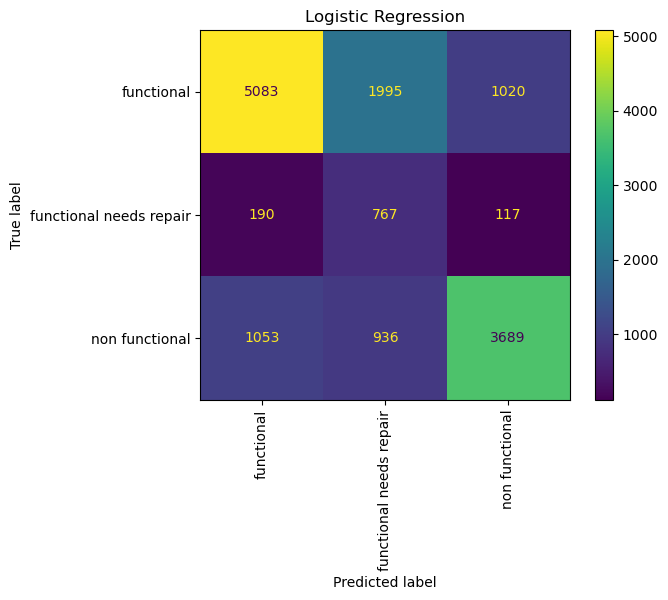

In [81]:
plt.style.use('default')
plot_confusion_matrix(lr3, X_test_filt, y_test)
plt.title('Logistic Regression')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

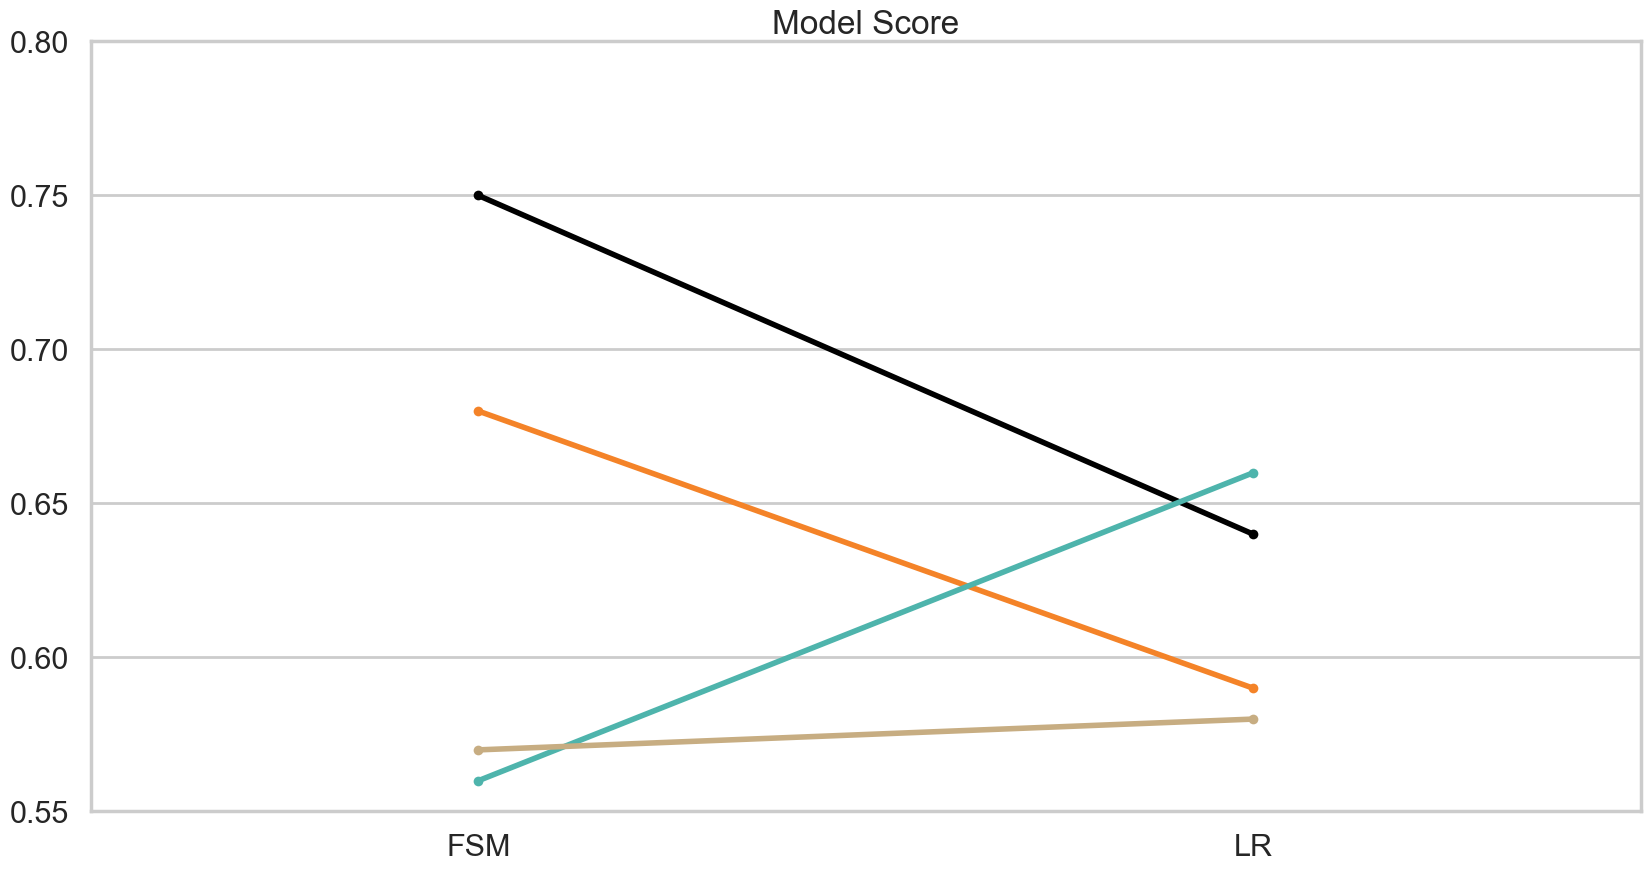

True

In [82]:
mf.plot_model_score(2)

#### Decision Tree

In [83]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filt, y_train_res)

DecisionTreeClassifier(random_state=42)

In [84]:
# Score on our training data
y_pred = dt.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [85]:
# Score on our testing data
y_pred = dt.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.77      0.79      8098
functional needs repair       0.33      0.47      0.39      1074
         non functional       0.77      0.75      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.64      0.66      0.65     14850
           weighted avg       0.76      0.74      0.75     14850



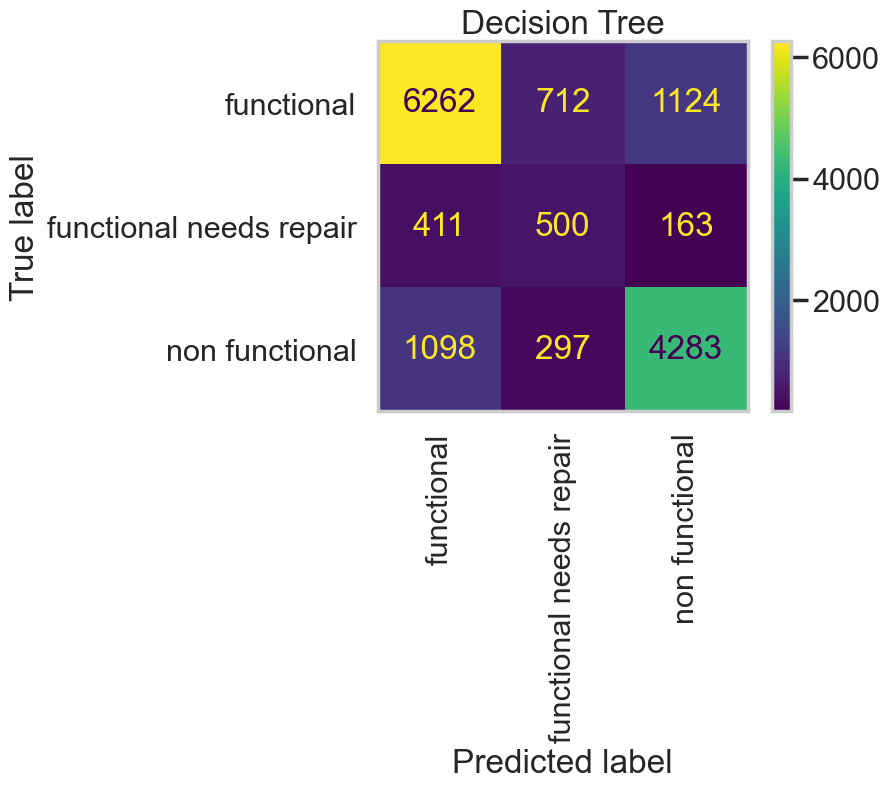

In [86]:
plot_confusion_matrix(dt, X_test_filt, y_test)
plt.title('Decision Tree')
plt.xticks(rotation='vertical')
plt.grid();

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

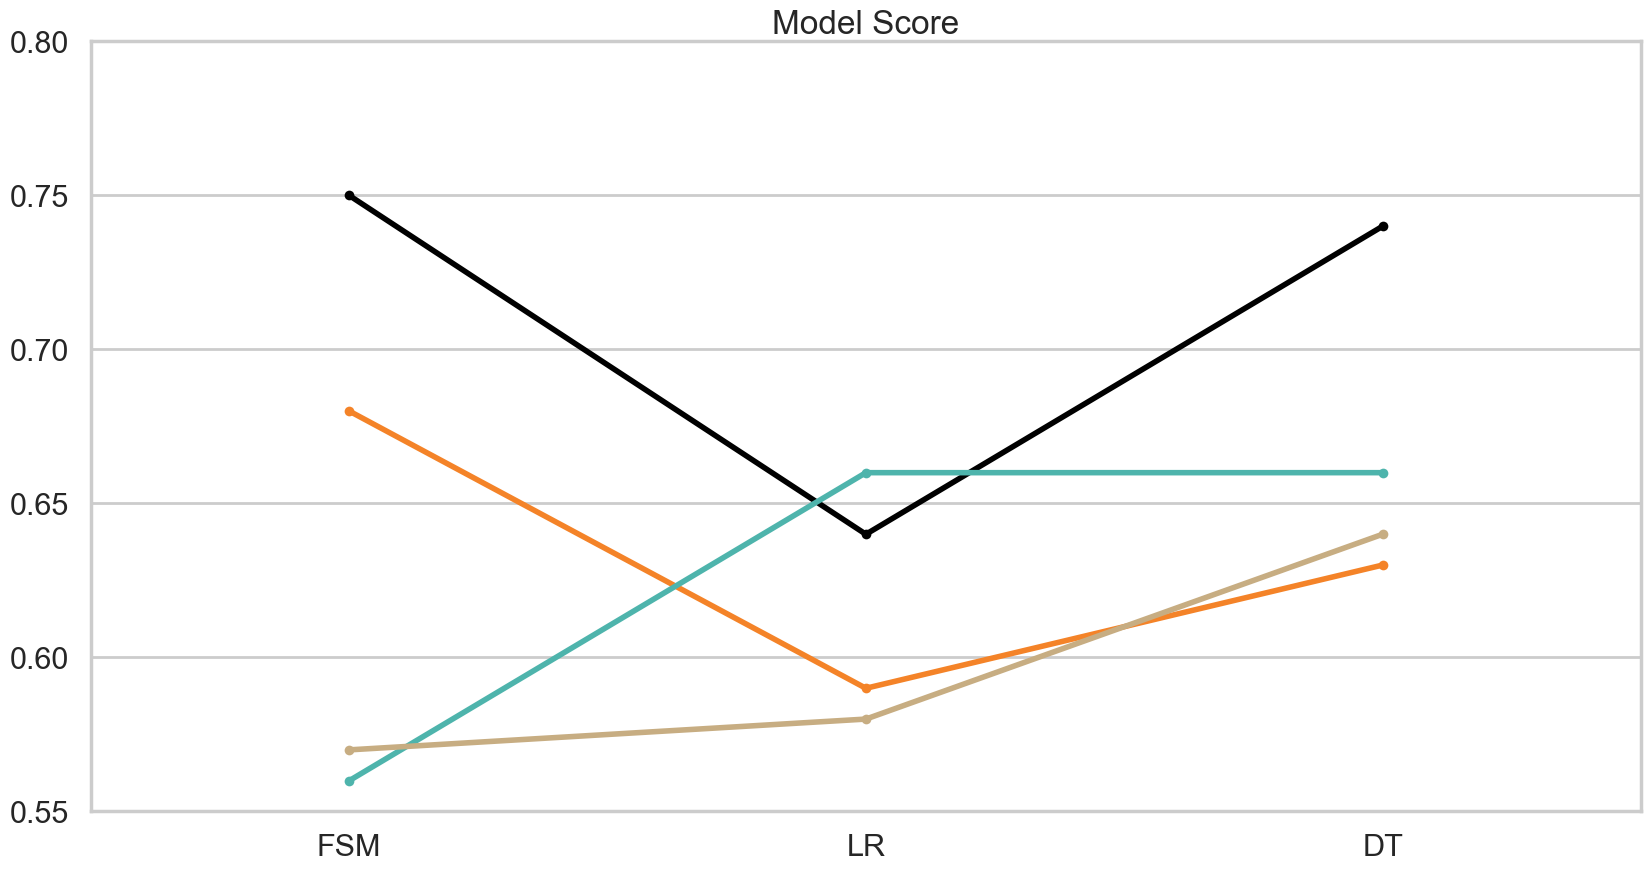

True

In [87]:
mf.plot_model_score(3)

#### KNN

In [88]:
knn1 = KNeighborsClassifier(n_neighbors = 5, p=1, weights='distance')
knn1.fit(X_train_filt, y_train_res)

KNeighborsClassifier(p=1, weights='distance')

In [89]:
# Score on our training data
y_pred = knn1.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.98      1.00      0.99     24161
functional needs repair       1.00      0.98      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           0.99     72483
              macro avg       0.99      0.99      0.99     72483
           weighted avg       0.99      0.99      0.99     72483



In [90]:
# Score on our testing data
y_pred = knn1.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.78      0.79      8098
functional needs repair       0.34      0.51      0.41      1074
         non functional       0.78      0.76      0.77      5678

               accuracy                           0.75     14850
              macro avg       0.64      0.68      0.66     14850
           weighted avg       0.77      0.75      0.76     14850



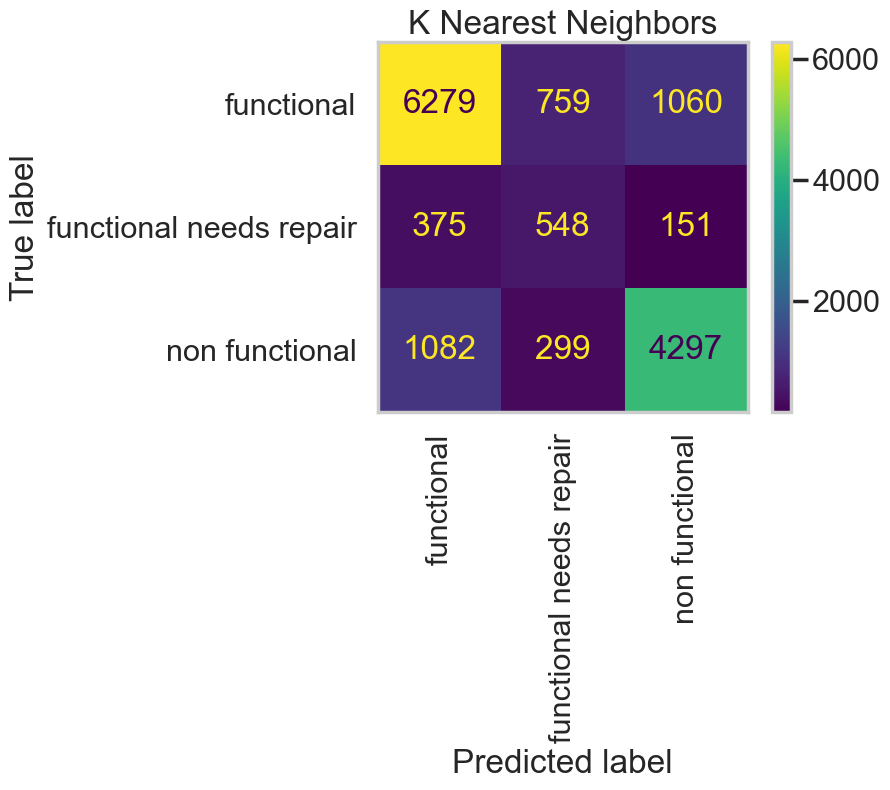

In [91]:
plot_confusion_matrix(knn1, X_test_filt, y_test)
plt.title('K Nearest Neighbors')
plt.xticks(rotation='vertical')
plt.grid();

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

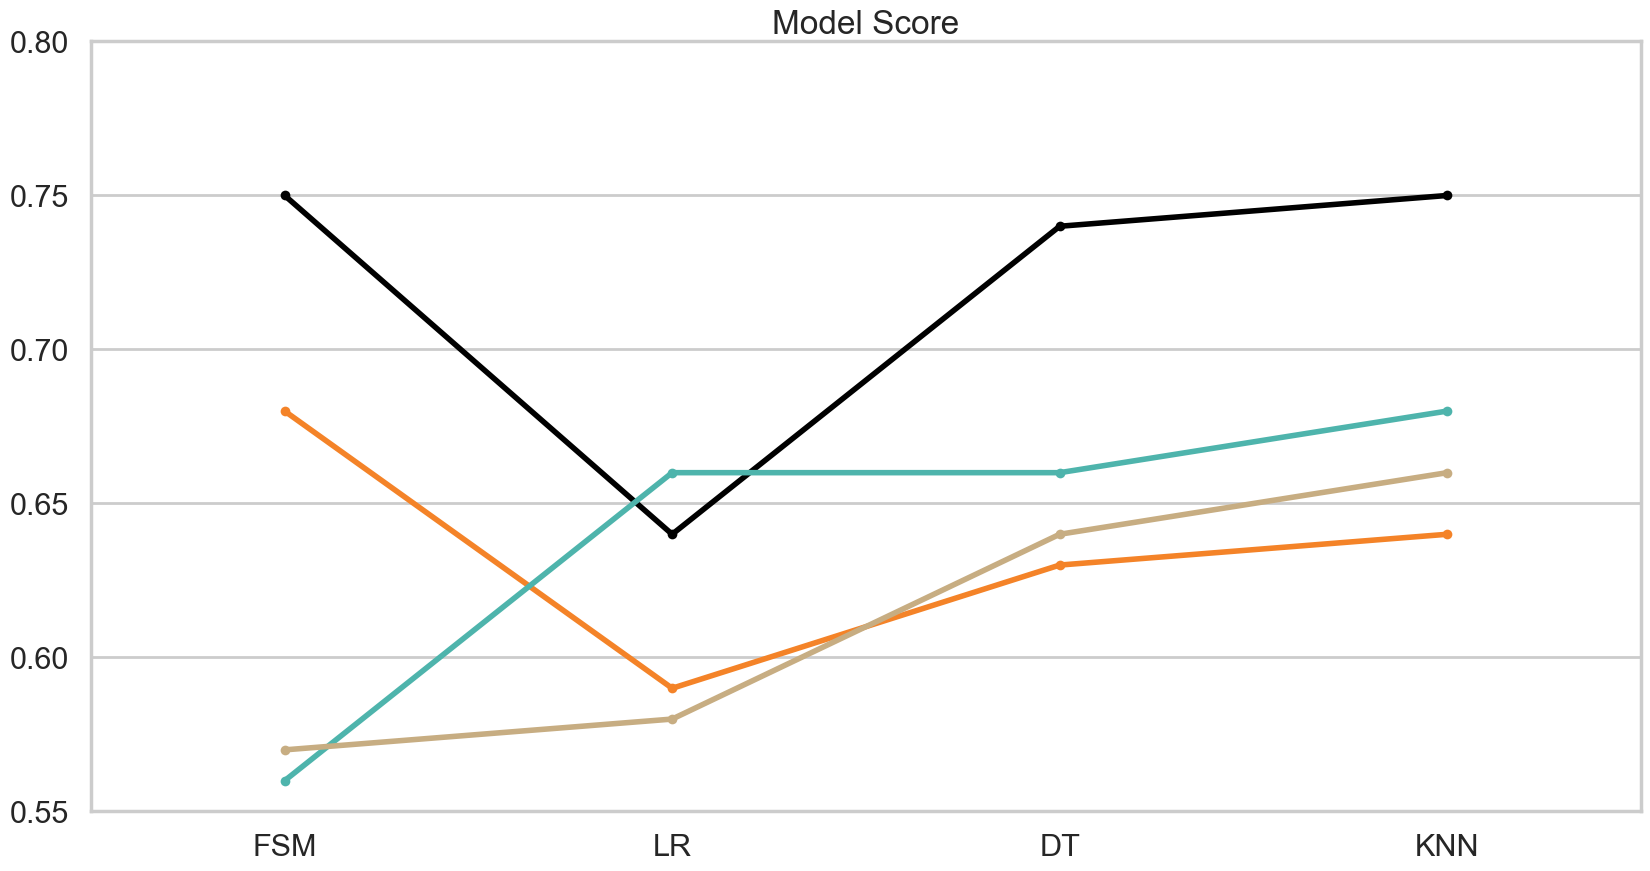

True

In [92]:
mf.plot_model_score(4)

## Ensemble Methods

Voting and Averaging are "weak" estimators. They are useful in the case that the models are already accurate

#### Voting Ensemble

To explain the idealogy behind voting ensembles, I'll start with an analagy. In a game show like who wants to be a millionare, a contestant can choose to "ask the audience". The contestant usually chooses the answer most voted for by the audience. According to stats from TV studios, the audience chooses the right answer over 90% of the time. This is due to a concept known as "wisdom of the crowds" referring to the collective intelligence of a group being superior to a single expert. Voting Ensembles use wisdom of the crowds to make its prediction based on the mode (or majority prediction) of multiple individual models.

In [93]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_voting = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)])

In [94]:
clf_voting.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))])

In [95]:
# Score on our training data
y_pred = clf_voting.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [96]:
# Score on our testing data
y_pred = clf_voting.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.81      8098
functional needs repair       0.35      0.54      0.42      1074
         non functional       0.82      0.75      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.70      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



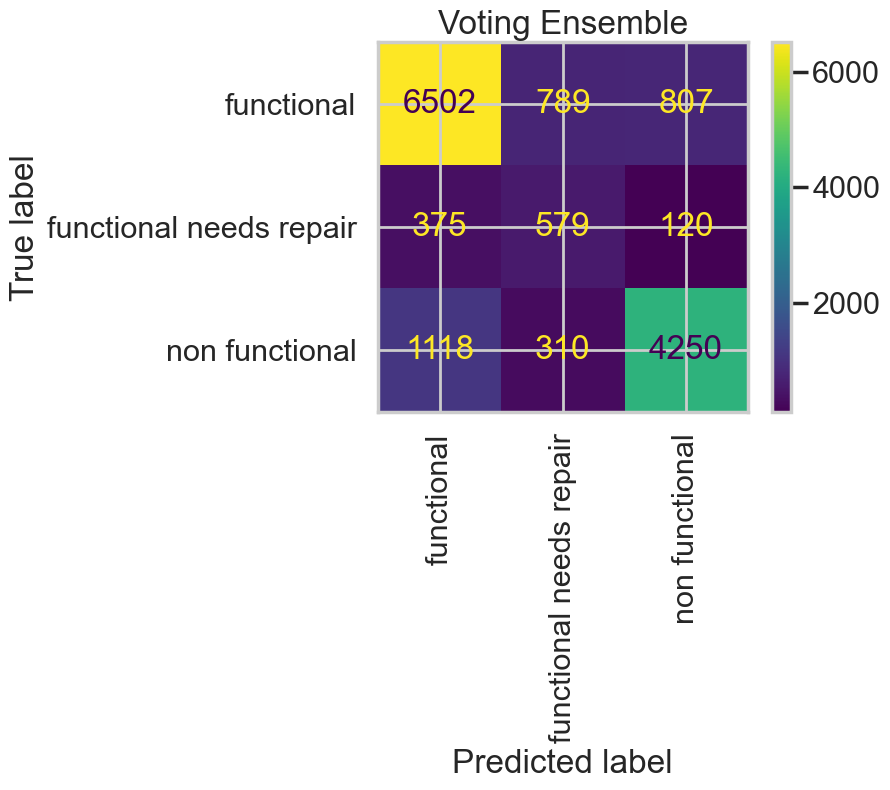

In [97]:
plot_confusion_matrix(clf_voting, X_test_filt, y_test)
plt.title('Voting Ensemble')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

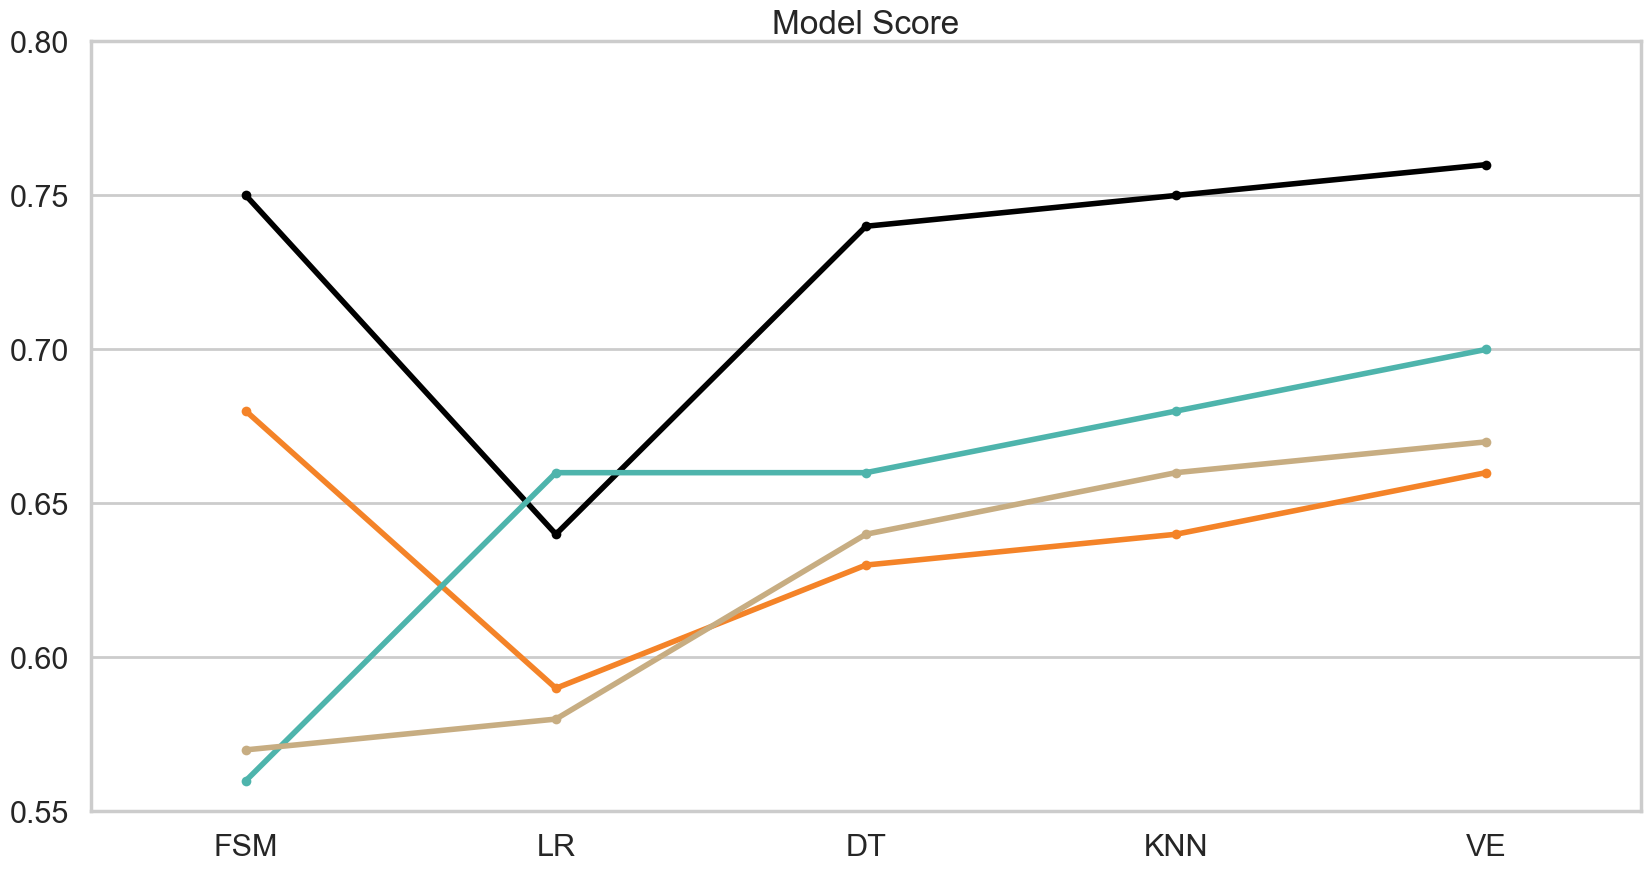

True

In [98]:
mf.plot_model_score(5)

#### Averaging Classifier

Similar to Voting but with specifying voting parameter to soft. Can assign different weights to each model

In [99]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_averaging = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)],
    voting = 'soft',
)
clf_averaging.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42, tol=10)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(p=1, weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [100]:
# Score on our training data
y_pred = clf_averaging.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [101]:
# Score on our testing data
y_pred = clf_averaging.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.35      0.51      0.41      1074
         non functional       0.80      0.76      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.69      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



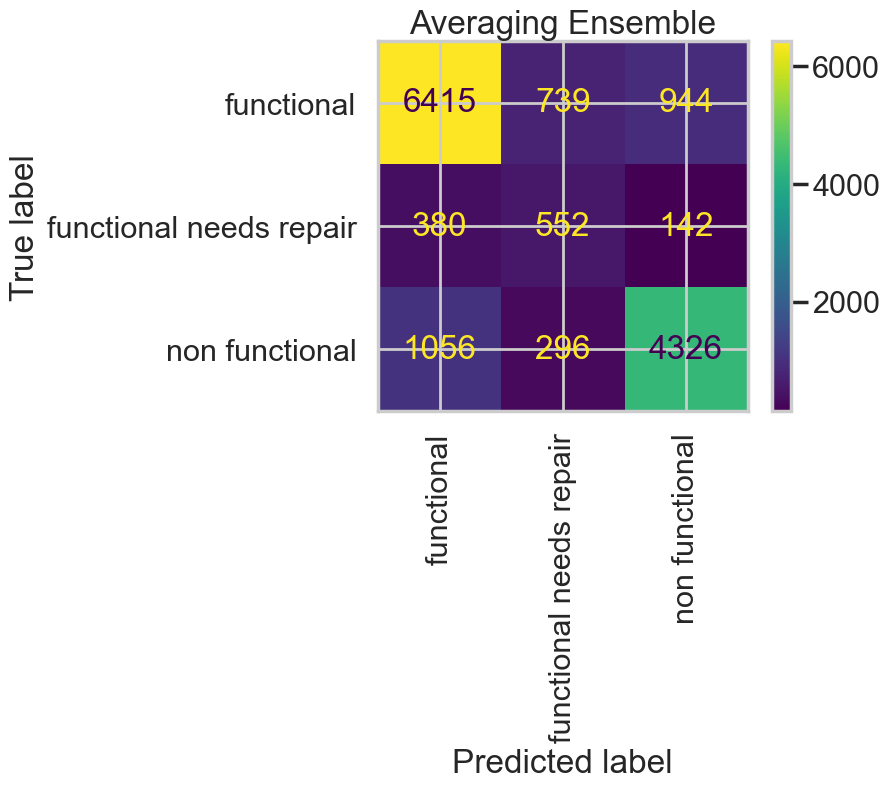

In [102]:
plot_confusion_matrix(clf_averaging, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

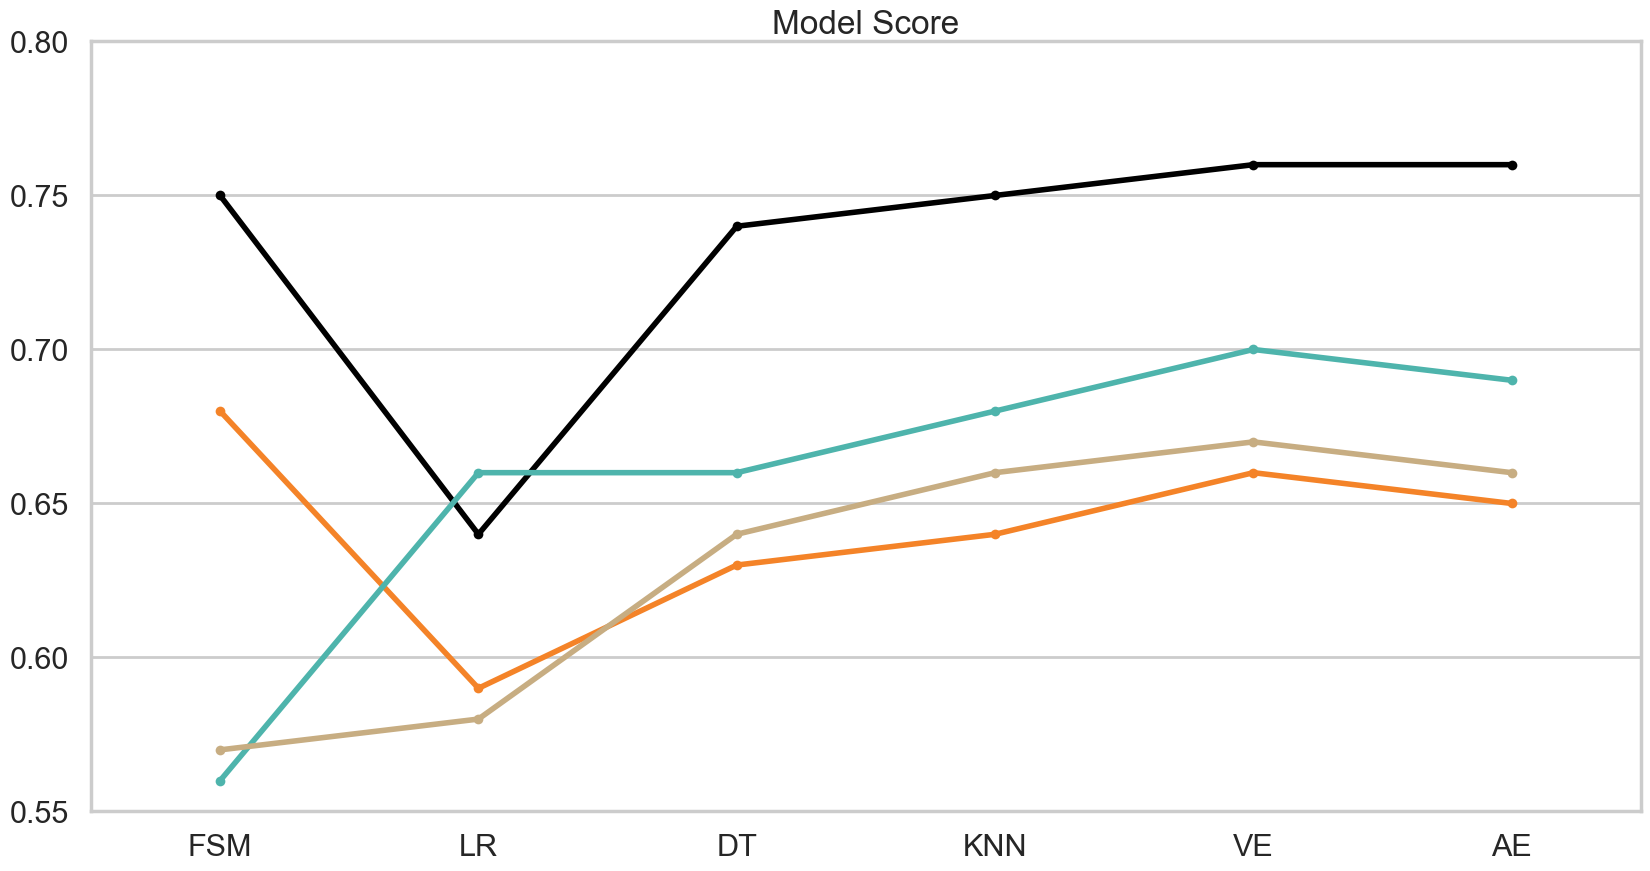

True

In [103]:
mf.plot_model_score(6)

#### Random Forest Classifier
Combines many decision trees into a forest of trees which use different samples of the data and features

In [104]:
rfc = RandomForestClassifier(n_estimators=2000, random_state=42)
rfc.fit(X_train_filt,y_train_res)

RandomForestClassifier(n_estimators=2000, random_state=42)

In [105]:
# Score on our training data
y_pred = rfc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [106]:
# Score on our testing data
y_pred = rfc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.82      0.82      8098
functional needs repair       0.40      0.50      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.70      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



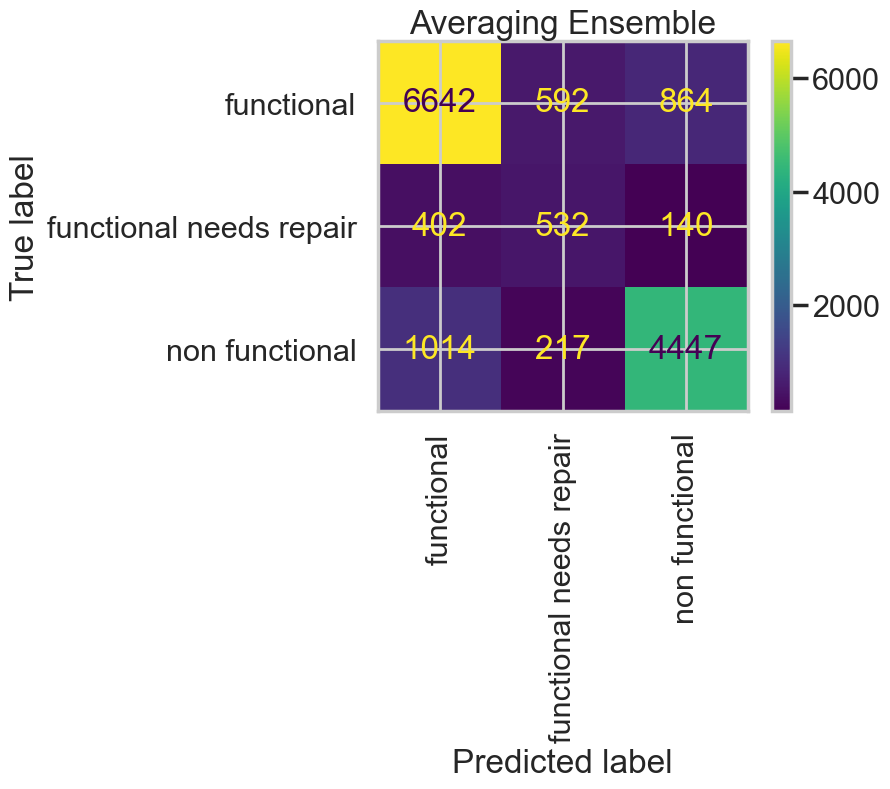

In [107]:
plot_confusion_matrix(rfc, X_test_filt, y_test)
plt.title('Averaging Ensemble')
plt.xticks(rotation='vertical');

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

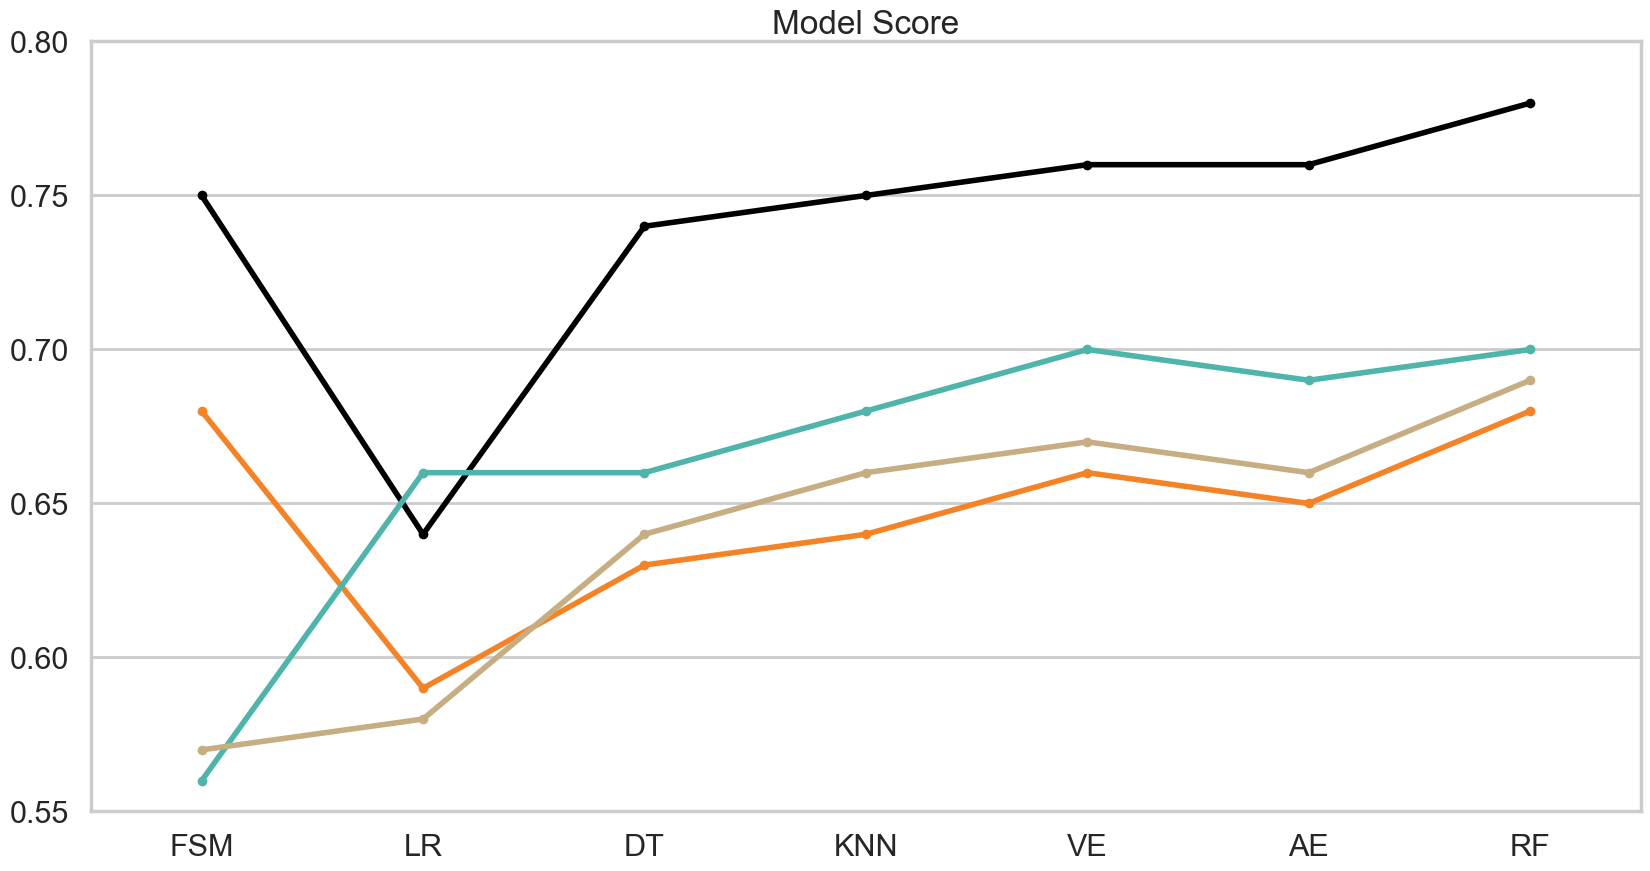

True

In [108]:
mf.plot_model_score(7)

### Boosting Algorithms
Boosting is another ensemble method based on iterative learning and sequential model building. It's a good choice when problems are complex, we have big datasets, and we need to apply parallel processing. They use decision trees as a base model and improve upon that by n_estimators number of times with a learning rate we can also tune

#### Ada Boost Classifier
Award winning algo

In [109]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train_filt, y_train_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [110]:
# Score on our training data
y_pred = adaboost_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.64      0.66      0.65     24161
functional needs repair       0.66      0.74      0.70     24161
         non functional       0.75      0.63      0.68     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [111]:
# Score on our testing data
y_pred = adaboost_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.65      0.71      8098
functional needs repair       0.20      0.63      0.30      1074
         non functional       0.77      0.63      0.69      5678

               accuracy                           0.64     14850
              macro avg       0.58      0.64      0.57     14850
           weighted avg       0.73      0.64      0.67     14850



<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

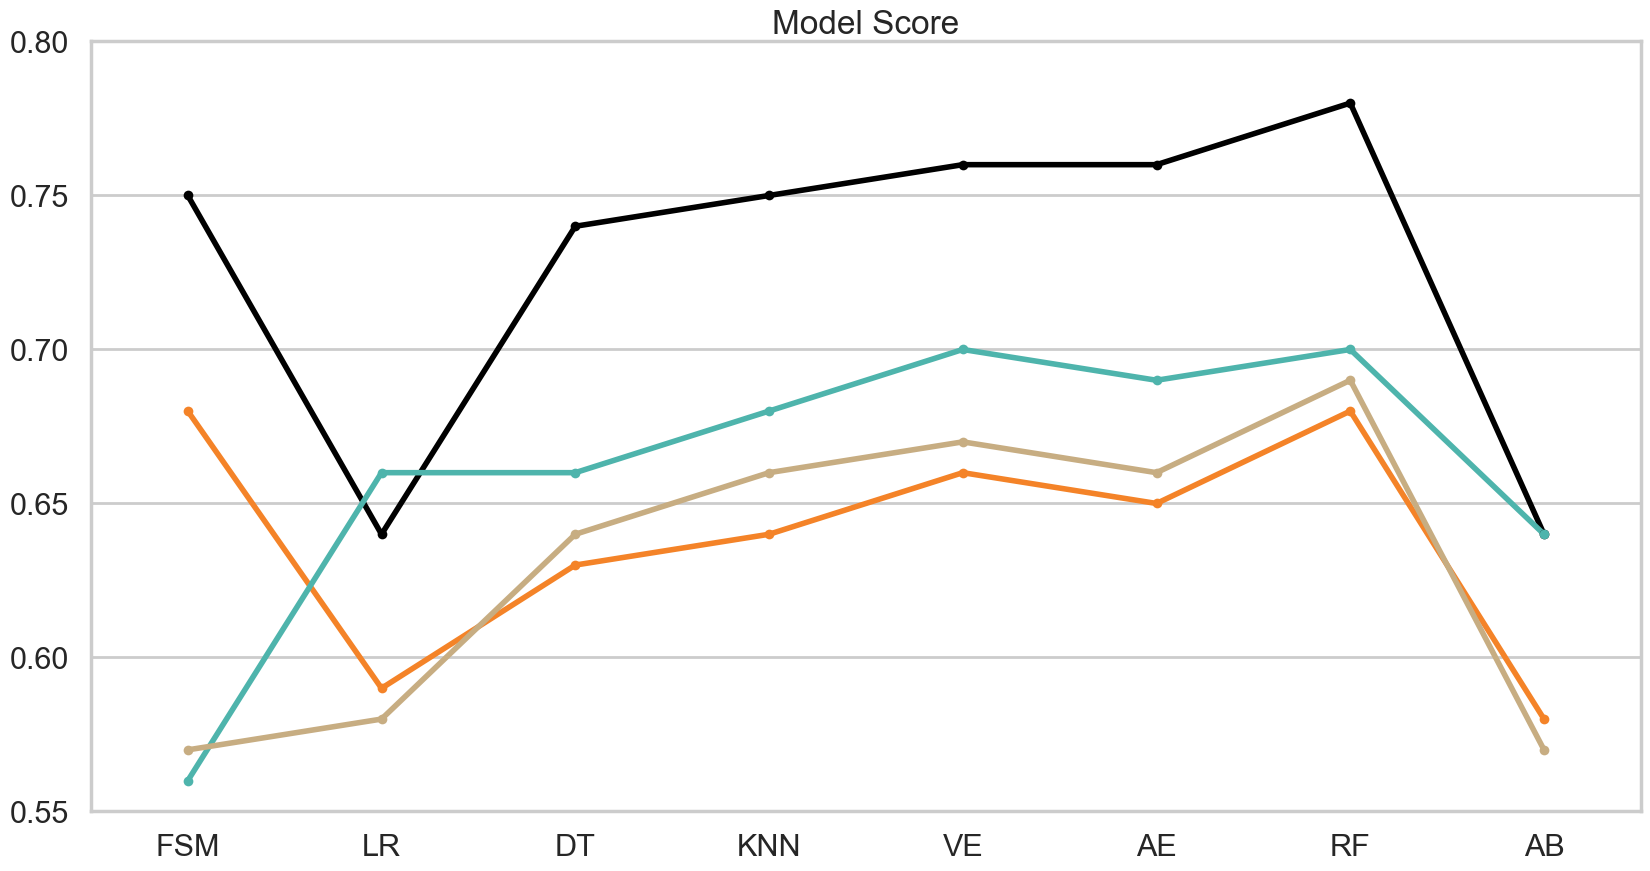

True

In [112]:
mf.plot_model_score(8)

#### Gradient Boosting Classifier

In [113]:
# Instantiate an GradientBoostingClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_clf.fit(X_train_filt, y_train_res)

GradientBoostingClassifier(random_state=42)

In [114]:
# Score on our training data
y_pred = gbt_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.67      0.74      0.70     24161
functional needs repair       0.72      0.80      0.76     24161
         non functional       0.83      0.65      0.73     24161

               accuracy                           0.73     72483
              macro avg       0.74      0.73      0.73     72483
           weighted avg       0.74      0.73      0.73     72483



In [115]:
# Score on our testing data
y_pred = gbt_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.73      0.75      8098
functional needs repair       0.24      0.63      0.34      1074
         non functional       0.82      0.63      0.71      5678

               accuracy                           0.69     14850
              macro avg       0.61      0.66      0.60     14850
           weighted avg       0.75      0.69      0.71     14850



#### Extreme Gradient Boosting Classifier

Optomized for distributed computing. Parallel training.

In [116]:
xgbc = xgb.XGBClassifier(max_depth=10, random_state=42)
xgbc.fit(X_train_filt,y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [117]:
# Score on our training data
y_pred = xgbc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.83      0.83     24161
functional needs repair       0.84      0.94      0.88     24161
         non functional       0.91      0.80      0.85     24161

               accuracy                           0.86     72483
              macro avg       0.86      0.86      0.85     72483
           weighted avg       0.86      0.86      0.85     72483



In [118]:
# Score on our testing data
y_pred = xgbc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.31      0.62      0.41      1074
         non functional       0.84      0.73      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

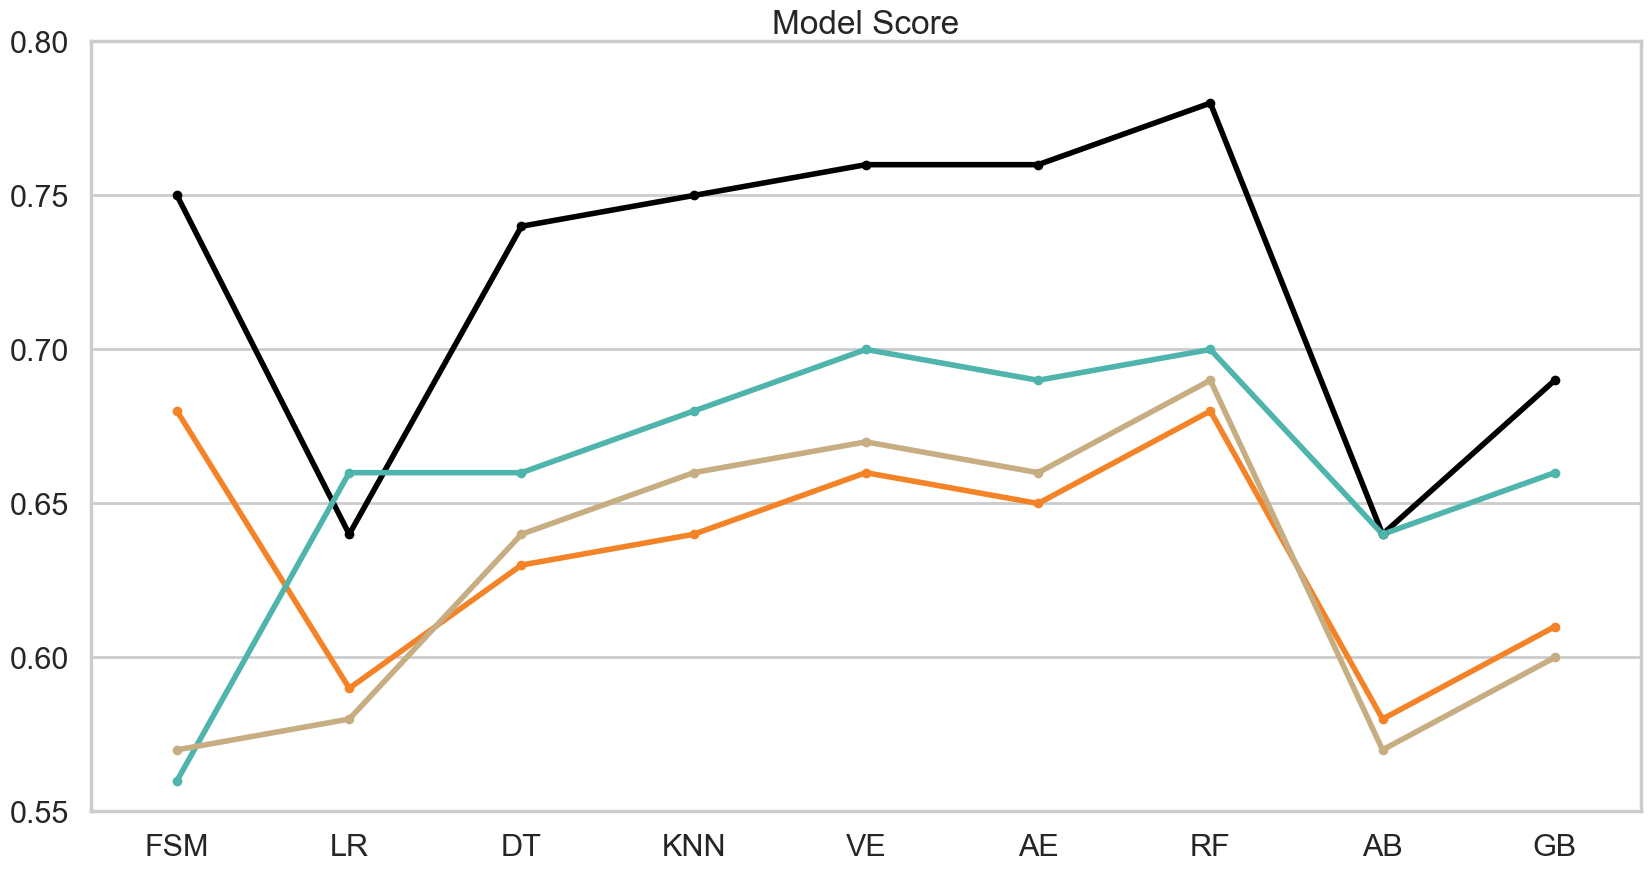

True

In [119]:
mf.plot_model_score(9)

#### Light Gradient Boosting

Released by Microsoft in 2017
Fast and efficient. Lighter in terms of space.
Optimized for parallel and GPU processing.
Useful for big datasets.

In [120]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
clf_lgb = lgb.LGBMClassifier(n_estimators=1000, seed=42)
clf_lgb.fit(X_train_filt,y_train_res)

LGBMClassifier(n_estimators=1000, seed=42)

In [121]:
# Score on our training data
y_pred = clf_lgb.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.90      0.90      0.90     24161
functional needs repair       0.92      0.96      0.94     24161
         non functional       0.95      0.90      0.92     24161

               accuracy                           0.92     72483
              macro avg       0.92      0.92      0.92     72483
           weighted avg       0.92      0.92      0.92     72483



In [122]:
# Score on our testing data
y_pred = clf_lgb.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.82      0.82      8098
functional needs repair       0.38      0.52      0.44      1074
         non functional       0.83      0.77      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.70      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



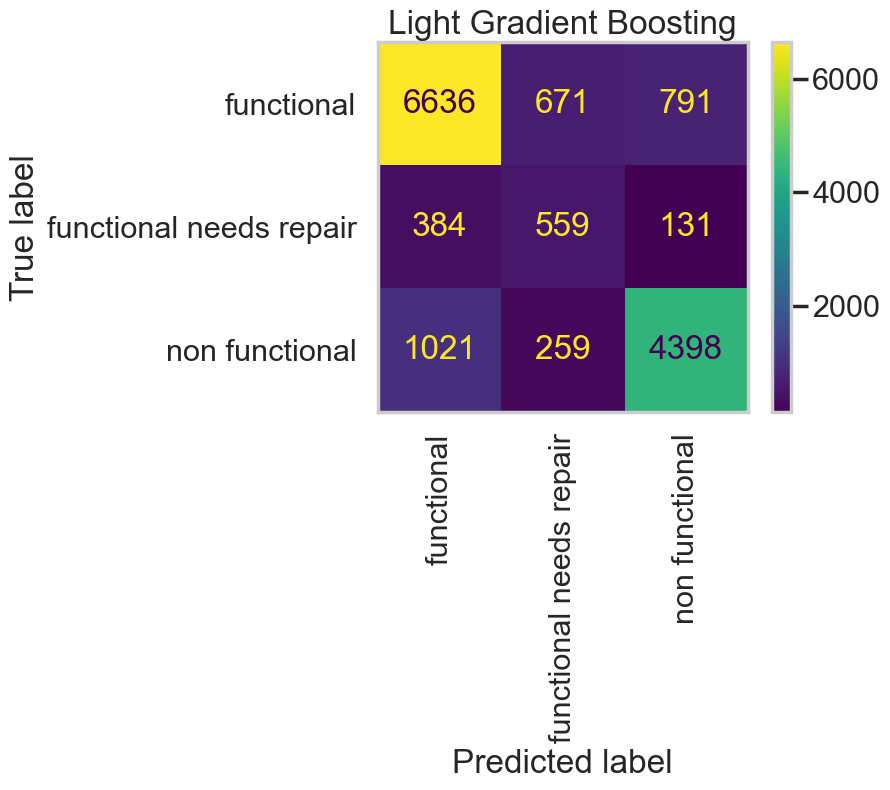

In [123]:
plot_confusion_matrix(clf_lgb, X_test_filt, y_test)
plt.title('Light Gradient Boosting')
plt.xticks(rotation='vertical')
plt.grid();

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

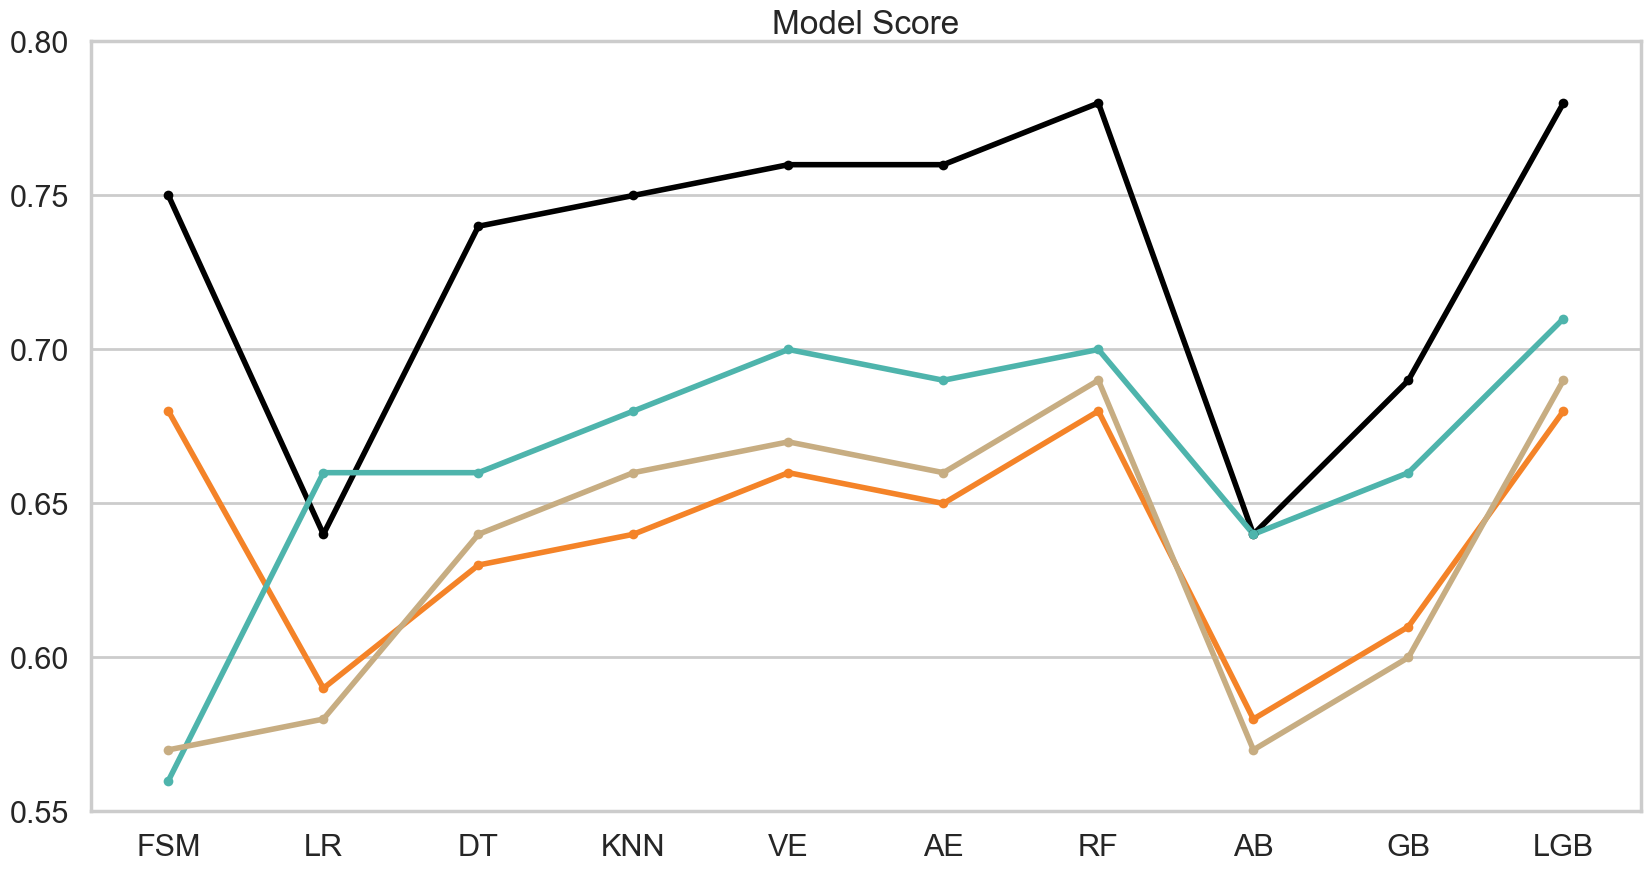

True

In [124]:
mf.plot_model_score(10)

#### Cat Boost
Open sourced by Yandex(april 2017). Built in handling of categorical features. Accurate and robust. Fast and scalable

In [127]:
# Default Params - n_estimators=1000, learning_rate=0.1, max_depth=3, 
reg_cat = cb.CatBoostClassifier(random_state=500)
reg_cat.fit(X_train_filt, y_train_res)

Learning rate set to 0.098445
0:	learn: 1.0606864	total: 235ms	remaining: 3m 55s
1:	learn: 1.0303624	total: 325ms	remaining: 2m 42s
2:	learn: 1.0062088	total: 409ms	remaining: 2m 15s
3:	learn: 0.9858888	total: 498ms	remaining: 2m 3s
4:	learn: 0.9683862	total: 586ms	remaining: 1m 56s
5:	learn: 0.9528839	total: 675ms	remaining: 1m 51s
6:	learn: 0.9399875	total: 765ms	remaining: 1m 48s
7:	learn: 0.9268566	total: 866ms	remaining: 1m 47s
8:	learn: 0.9171405	total: 946ms	remaining: 1m 44s
9:	learn: 0.9050462	total: 1.04s	remaining: 1m 42s
10:	learn: 0.8970508	total: 1.12s	remaining: 1m 40s
11:	learn: 0.8873743	total: 1.2s	remaining: 1m 39s
12:	learn: 0.8793197	total: 1.29s	remaining: 1m 38s
13:	learn: 0.8718654	total: 1.38s	remaining: 1m 37s
14:	learn: 0.8655408	total: 1.46s	remaining: 1m 35s
15:	learn: 0.8593133	total: 1.56s	remaining: 1m 36s
16:	learn: 0.8538865	total: 1.66s	remaining: 1m 35s
17:	learn: 0.8497018	total: 1.74s	remaining: 1m 34s
18:	learn: 0.8442527	total: 1.84s	remaining: 1

158:	learn: 0.6321682	total: 13.9s	remaining: 1m 13s
159:	learn: 0.6315023	total: 14s	remaining: 1m 13s
160:	learn: 0.6306587	total: 14.1s	remaining: 1m 13s
161:	learn: 0.6297532	total: 14.2s	remaining: 1m 13s
162:	learn: 0.6291302	total: 14.2s	remaining: 1m 13s
163:	learn: 0.6285392	total: 14.3s	remaining: 1m 12s
164:	learn: 0.6279582	total: 14.4s	remaining: 1m 12s
165:	learn: 0.6265451	total: 14.5s	remaining: 1m 12s
166:	learn: 0.6257131	total: 14.6s	remaining: 1m 12s
167:	learn: 0.6249355	total: 14.7s	remaining: 1m 12s
168:	learn: 0.6242973	total: 14.7s	remaining: 1m 12s
169:	learn: 0.6236678	total: 14.8s	remaining: 1m 12s
170:	learn: 0.6230231	total: 14.9s	remaining: 1m 12s
171:	learn: 0.6221742	total: 15s	remaining: 1m 12s
172:	learn: 0.6216776	total: 15.1s	remaining: 1m 12s
173:	learn: 0.6210536	total: 15.2s	remaining: 1m 11s
174:	learn: 0.6202028	total: 15.2s	remaining: 1m 11s
175:	learn: 0.6195416	total: 15.3s	remaining: 1m 11s
176:	learn: 0.6189755	total: 15.4s	remaining: 1m 1

318:	learn: 0.5522561	total: 27.5s	remaining: 58.7s
319:	learn: 0.5517682	total: 27.6s	remaining: 58.6s
320:	learn: 0.5514375	total: 27.7s	remaining: 58.5s
321:	learn: 0.5512430	total: 27.8s	remaining: 58.4s
322:	learn: 0.5508743	total: 27.8s	remaining: 58.4s
323:	learn: 0.5505757	total: 27.9s	remaining: 58.3s
324:	learn: 0.5502364	total: 28s	remaining: 58.2s
325:	learn: 0.5498895	total: 28.1s	remaining: 58.1s
326:	learn: 0.5496939	total: 28.2s	remaining: 58s
327:	learn: 0.5494488	total: 28.3s	remaining: 58s
328:	learn: 0.5492085	total: 28.4s	remaining: 57.9s
329:	learn: 0.5489460	total: 28.5s	remaining: 57.8s
330:	learn: 0.5484471	total: 28.5s	remaining: 57.7s
331:	learn: 0.5481227	total: 28.6s	remaining: 57.6s
332:	learn: 0.5477791	total: 28.7s	remaining: 57.5s
333:	learn: 0.5474931	total: 28.8s	remaining: 57.4s
334:	learn: 0.5472239	total: 28.9s	remaining: 57.3s
335:	learn: 0.5469390	total: 29s	remaining: 57.3s
336:	learn: 0.5464859	total: 29.1s	remaining: 57.2s
337:	learn: 0.546114

478:	learn: 0.5096059	total: 41.8s	remaining: 45.5s
479:	learn: 0.5093722	total: 41.9s	remaining: 45.4s
480:	learn: 0.5092090	total: 42s	remaining: 45.3s
481:	learn: 0.5089456	total: 42.1s	remaining: 45.3s
482:	learn: 0.5088129	total: 42.2s	remaining: 45.2s
483:	learn: 0.5086775	total: 42.3s	remaining: 45.1s
484:	learn: 0.5084830	total: 42.4s	remaining: 45s
485:	learn: 0.5083430	total: 42.5s	remaining: 44.9s
486:	learn: 0.5082022	total: 42.6s	remaining: 44.8s
487:	learn: 0.5079499	total: 42.7s	remaining: 44.8s
488:	learn: 0.5076867	total: 42.8s	remaining: 44.7s
489:	learn: 0.5074081	total: 42.9s	remaining: 44.6s
490:	learn: 0.5072111	total: 43s	remaining: 44.5s
491:	learn: 0.5069346	total: 43.1s	remaining: 44.5s
492:	learn: 0.5066801	total: 43.2s	remaining: 44.4s
493:	learn: 0.5065027	total: 43.2s	remaining: 44.3s
494:	learn: 0.5063126	total: 43.3s	remaining: 44.2s
495:	learn: 0.5061190	total: 43.4s	remaining: 44.1s
496:	learn: 0.5059473	total: 43.5s	remaining: 44s
497:	learn: 0.505703

637:	learn: 0.4809858	total: 56s	remaining: 31.8s
638:	learn: 0.4808706	total: 56.1s	remaining: 31.7s
639:	learn: 0.4807412	total: 56.2s	remaining: 31.6s
640:	learn: 0.4805611	total: 56.3s	remaining: 31.5s
641:	learn: 0.4803482	total: 56.4s	remaining: 31.4s
642:	learn: 0.4801519	total: 56.5s	remaining: 31.3s
643:	learn: 0.4799842	total: 56.5s	remaining: 31.3s
644:	learn: 0.4797984	total: 56.6s	remaining: 31.2s
645:	learn: 0.4796116	total: 56.7s	remaining: 31.1s
646:	learn: 0.4794660	total: 56.8s	remaining: 31s
647:	learn: 0.4793254	total: 56.9s	remaining: 30.9s
648:	learn: 0.4790923	total: 57s	remaining: 30.8s
649:	learn: 0.4789215	total: 57.1s	remaining: 30.7s
650:	learn: 0.4787516	total: 57.2s	remaining: 30.6s
651:	learn: 0.4785552	total: 57.3s	remaining: 30.6s
652:	learn: 0.4784039	total: 57.3s	remaining: 30.5s
653:	learn: 0.4782125	total: 57.4s	remaining: 30.4s
654:	learn: 0.4781136	total: 57.5s	remaining: 30.3s
655:	learn: 0.4779282	total: 57.6s	remaining: 30.2s
656:	learn: 0.4777

798:	learn: 0.4587727	total: 1m 9s	remaining: 17.6s
799:	learn: 0.4586695	total: 1m 10s	remaining: 17.5s
800:	learn: 0.4585322	total: 1m 10s	remaining: 17.4s
801:	learn: 0.4584298	total: 1m 10s	remaining: 17.3s
802:	learn: 0.4583744	total: 1m 10s	remaining: 17.2s
803:	learn: 0.4581314	total: 1m 10s	remaining: 17.2s
804:	learn: 0.4580540	total: 1m 10s	remaining: 17.1s
805:	learn: 0.4579720	total: 1m 10s	remaining: 17s
806:	learn: 0.4578682	total: 1m 10s	remaining: 16.9s
807:	learn: 0.4577494	total: 1m 10s	remaining: 16.8s
808:	learn: 0.4576166	total: 1m 10s	remaining: 16.7s
809:	learn: 0.4575554	total: 1m 10s	remaining: 16.6s
810:	learn: 0.4574256	total: 1m 10s	remaining: 16.5s
811:	learn: 0.4573810	total: 1m 11s	remaining: 16.4s
812:	learn: 0.4572734	total: 1m 11s	remaining: 16.4s
813:	learn: 0.4571488	total: 1m 11s	remaining: 16.3s
814:	learn: 0.4570701	total: 1m 11s	remaining: 16.2s
815:	learn: 0.4569165	total: 1m 11s	remaining: 16.1s
816:	learn: 0.4567736	total: 1m 11s	remaining: 16

955:	learn: 0.4407648	total: 1m 22s	remaining: 3.82s
956:	learn: 0.4406871	total: 1m 23s	remaining: 3.73s
957:	learn: 0.4406178	total: 1m 23s	remaining: 3.64s
958:	learn: 0.4405443	total: 1m 23s	remaining: 3.56s
959:	learn: 0.4404787	total: 1m 23s	remaining: 3.47s
960:	learn: 0.4404087	total: 1m 23s	remaining: 3.38s
961:	learn: 0.4403194	total: 1m 23s	remaining: 3.29s
962:	learn: 0.4402025	total: 1m 23s	remaining: 3.21s
963:	learn: 0.4400646	total: 1m 23s	remaining: 3.12s
964:	learn: 0.4399892	total: 1m 23s	remaining: 3.03s
965:	learn: 0.4398225	total: 1m 23s	remaining: 2.95s
966:	learn: 0.4397013	total: 1m 23s	remaining: 2.86s
967:	learn: 0.4396079	total: 1m 23s	remaining: 2.77s
968:	learn: 0.4394529	total: 1m 24s	remaining: 2.69s
969:	learn: 0.4393167	total: 1m 24s	remaining: 2.6s
970:	learn: 0.4392656	total: 1m 24s	remaining: 2.51s
971:	learn: 0.4391696	total: 1m 24s	remaining: 2.43s
972:	learn: 0.4390393	total: 1m 24s	remaining: 2.34s
973:	learn: 0.4389733	total: 1m 24s	remaining: 

In [128]:
# Score on our training data
y_pred = reg_cat.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.80     24161
functional needs repair       0.84      0.91      0.87     24161
         non functional       0.88      0.79      0.83     24161

               accuracy                           0.84     72483
              macro avg       0.84      0.84      0.84     72483
           weighted avg       0.84      0.84      0.84     72483



In [129]:
# # Score on our testing data
y_pred = reg_cat.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.32      0.60      0.41      1074
         non functional       0.83      0.75      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.67     14850
           weighted avg       0.79      0.75      0.77     14850



<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

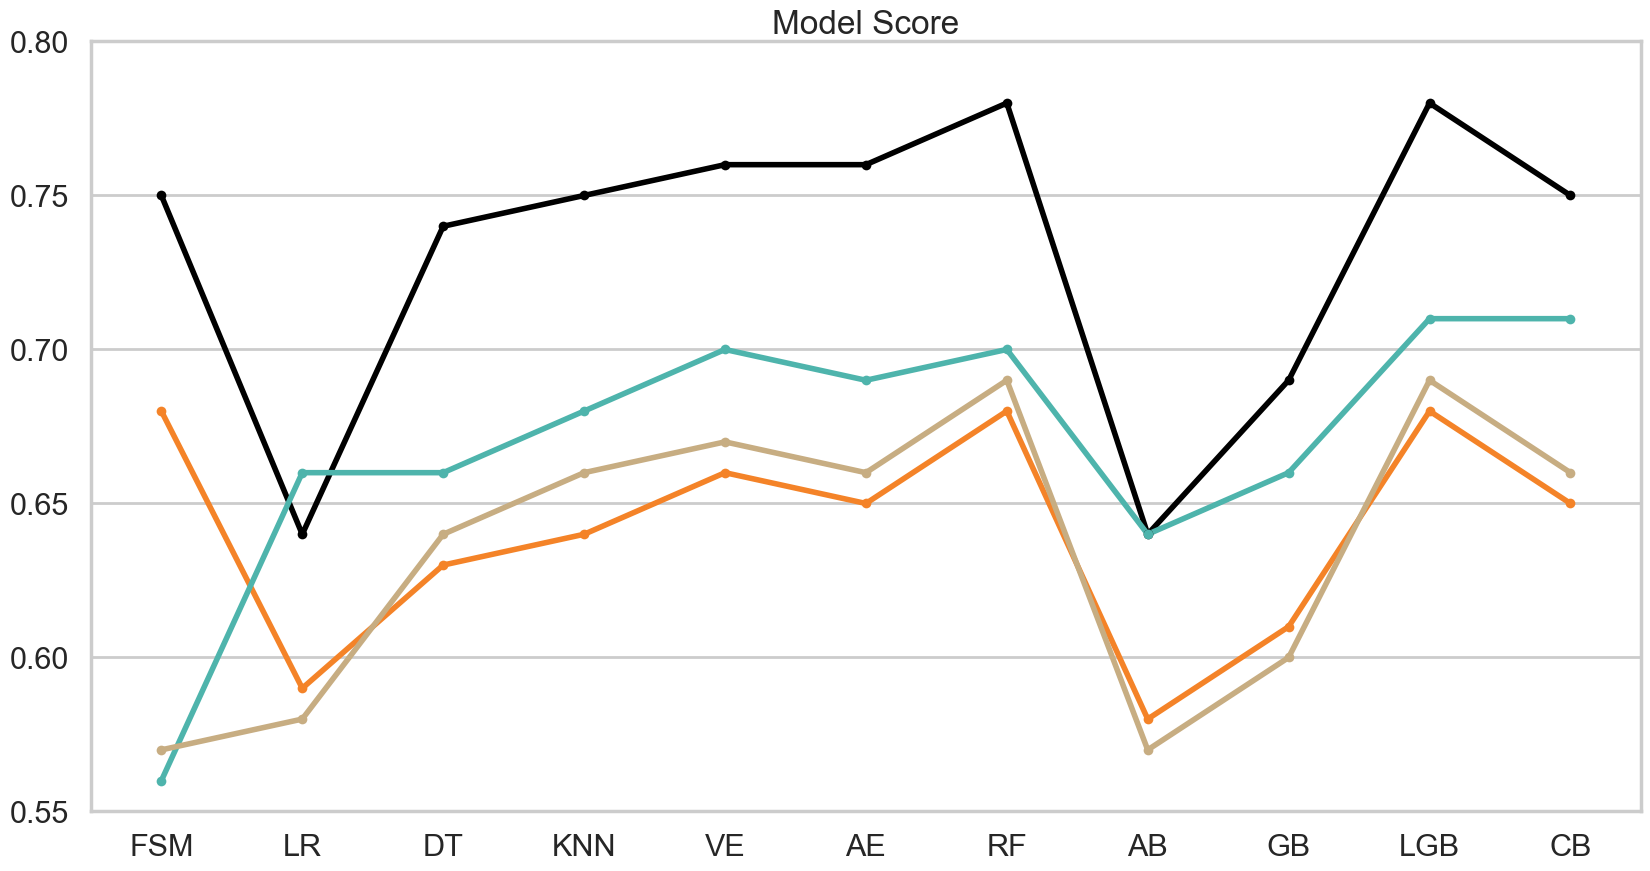

True

In [130]:
mf.plot_model_score(11)

### Stacking

Combining models together. Good choice when Voting/Averaging dont have great results

In [131]:
# Parameters = classifiers = [clf1, clf2, clf3...], meta_classifiers=clf_meta, use_probas=False, use_features_in_secondary=False
classifiers = [lr3, knn1, dt, clf_voting, clf_averaging, rfc, adaboost_clf, gbt_clf, xgbc, clf_lgb, reg_cat]

clf_meta = clf_lgb

clf_stack = StackingClassifier(classifiers, clf_meta, use_features_in_secondary=True)

Target classes need to be numerical for StackingClassifier to work. Use Label Encoder for this

In [132]:
le = LabelEncoder()
le.fit(y_train_res)

LabelEncoder()

In [133]:
y_train_le = le.fit_transform(y_train_res)
y_test_le = le.transform(y_test)

In [134]:
clf_stack.fit(X_train_filt, y_train_le)

Learning rate set to 0.098445
0:	learn: 1.0606864	total: 124ms	remaining: 2m 4s
1:	learn: 1.0303624	total: 223ms	remaining: 1m 51s
2:	learn: 1.0062088	total: 321ms	remaining: 1m 46s
3:	learn: 0.9858888	total: 424ms	remaining: 1m 45s
4:	learn: 0.9683862	total: 528ms	remaining: 1m 45s
5:	learn: 0.9528839	total: 628ms	remaining: 1m 44s
6:	learn: 0.9399875	total: 719ms	remaining: 1m 41s
7:	learn: 0.9268566	total: 832ms	remaining: 1m 43s
8:	learn: 0.9171405	total: 935ms	remaining: 1m 42s
9:	learn: 0.9050462	total: 1.04s	remaining: 1m 43s
10:	learn: 0.8970508	total: 1.14s	remaining: 1m 42s
11:	learn: 0.8873743	total: 1.25s	remaining: 1m 42s
12:	learn: 0.8793197	total: 1.34s	remaining: 1m 41s
13:	learn: 0.8718654	total: 1.43s	remaining: 1m 40s
14:	learn: 0.8655408	total: 1.51s	remaining: 1m 39s
15:	learn: 0.8593133	total: 1.62s	remaining: 1m 39s
16:	learn: 0.8538865	total: 1.72s	remaining: 1m 39s
17:	learn: 0.8497018	total: 1.8s	remaining: 1m 38s
18:	learn: 0.8442527	total: 1.9s	remaining: 1m

158:	learn: 0.6321682	total: 15.1s	remaining: 1m 19s
159:	learn: 0.6315023	total: 15.2s	remaining: 1m 19s
160:	learn: 0.6306587	total: 15.3s	remaining: 1m 19s
161:	learn: 0.6297532	total: 15.4s	remaining: 1m 19s
162:	learn: 0.6291302	total: 15.5s	remaining: 1m 19s
163:	learn: 0.6285392	total: 15.6s	remaining: 1m 19s
164:	learn: 0.6279582	total: 15.7s	remaining: 1m 19s
165:	learn: 0.6265451	total: 15.8s	remaining: 1m 19s
166:	learn: 0.6257131	total: 15.9s	remaining: 1m 19s
167:	learn: 0.6249355	total: 16s	remaining: 1m 19s
168:	learn: 0.6242973	total: 16.1s	remaining: 1m 18s
169:	learn: 0.6236678	total: 16.1s	remaining: 1m 18s
170:	learn: 0.6230231	total: 16.2s	remaining: 1m 18s
171:	learn: 0.6221742	total: 16.3s	remaining: 1m 18s
172:	learn: 0.6216776	total: 16.4s	remaining: 1m 18s
173:	learn: 0.6210536	total: 16.5s	remaining: 1m 18s
174:	learn: 0.6202028	total: 16.6s	remaining: 1m 18s
175:	learn: 0.6195416	total: 16.7s	remaining: 1m 18s
176:	learn: 0.6189755	total: 16.8s	remaining: 1m

315:	learn: 0.5532643	total: 29.5s	remaining: 1m 3s
316:	learn: 0.5528483	total: 29.6s	remaining: 1m 3s
317:	learn: 0.5524839	total: 29.7s	remaining: 1m 3s
318:	learn: 0.5522561	total: 29.8s	remaining: 1m 3s
319:	learn: 0.5517682	total: 29.9s	remaining: 1m 3s
320:	learn: 0.5514375	total: 30s	remaining: 1m 3s
321:	learn: 0.5512430	total: 30s	remaining: 1m 3s
322:	learn: 0.5508743	total: 30.1s	remaining: 1m 3s
323:	learn: 0.5505757	total: 30.2s	remaining: 1m 3s
324:	learn: 0.5502364	total: 30.3s	remaining: 1m 2s
325:	learn: 0.5498895	total: 30.4s	remaining: 1m 2s
326:	learn: 0.5496939	total: 30.5s	remaining: 1m 2s
327:	learn: 0.5494488	total: 30.6s	remaining: 1m 2s
328:	learn: 0.5492085	total: 30.7s	remaining: 1m 2s
329:	learn: 0.5489460	total: 30.8s	remaining: 1m 2s
330:	learn: 0.5484471	total: 30.8s	remaining: 1m 2s
331:	learn: 0.5481227	total: 30.9s	remaining: 1m 2s
332:	learn: 0.5477791	total: 31s	remaining: 1m 2s
333:	learn: 0.5474931	total: 31.1s	remaining: 1m 2s
334:	learn: 0.5472

477:	learn: 0.5097522	total: 44.2s	remaining: 48.3s
478:	learn: 0.5096059	total: 44.3s	remaining: 48.2s
479:	learn: 0.5093722	total: 44.4s	remaining: 48.1s
480:	learn: 0.5092090	total: 44.5s	remaining: 48s
481:	learn: 0.5089456	total: 44.6s	remaining: 47.9s
482:	learn: 0.5088129	total: 44.7s	remaining: 47.8s
483:	learn: 0.5086775	total: 44.8s	remaining: 47.7s
484:	learn: 0.5084830	total: 44.8s	remaining: 47.6s
485:	learn: 0.5083430	total: 44.9s	remaining: 47.5s
486:	learn: 0.5082022	total: 45s	remaining: 47.4s
487:	learn: 0.5079499	total: 45.1s	remaining: 47.3s
488:	learn: 0.5076867	total: 45.2s	remaining: 47.2s
489:	learn: 0.5074081	total: 45.3s	remaining: 47.1s
490:	learn: 0.5072111	total: 45.4s	remaining: 47.1s
491:	learn: 0.5069346	total: 45.5s	remaining: 47s
492:	learn: 0.5066801	total: 45.6s	remaining: 46.9s
493:	learn: 0.5065027	total: 45.7s	remaining: 46.8s
494:	learn: 0.5063126	total: 45.7s	remaining: 46.7s
495:	learn: 0.5061190	total: 45.8s	remaining: 46.6s
496:	learn: 0.5059

637:	learn: 0.4809858	total: 59.1s	remaining: 33.5s
638:	learn: 0.4808706	total: 59.2s	remaining: 33.4s
639:	learn: 0.4807412	total: 59.3s	remaining: 33.3s
640:	learn: 0.4805611	total: 59.4s	remaining: 33.2s
641:	learn: 0.4803482	total: 59.4s	remaining: 33.1s
642:	learn: 0.4801519	total: 59.5s	remaining: 33s
643:	learn: 0.4799842	total: 59.6s	remaining: 33s
644:	learn: 0.4797984	total: 59.7s	remaining: 32.9s
645:	learn: 0.4796116	total: 59.8s	remaining: 32.8s
646:	learn: 0.4794660	total: 59.9s	remaining: 32.7s
647:	learn: 0.4793254	total: 60s	remaining: 32.6s
648:	learn: 0.4790923	total: 1m	remaining: 32.5s
649:	learn: 0.4789215	total: 1m	remaining: 32.4s
650:	learn: 0.4787516	total: 1m	remaining: 32.3s
651:	learn: 0.4785552	total: 1m	remaining: 32.2s
652:	learn: 0.4784039	total: 1m	remaining: 32.1s
653:	learn: 0.4782125	total: 1m	remaining: 32s
654:	learn: 0.4781136	total: 1m	remaining: 31.9s
655:	learn: 0.4779282	total: 1m	remaining: 31.8s
656:	learn: 0.4777608	total: 1m	remaining: 3

796:	learn: 0.4590131	total: 1m 13s	remaining: 18.8s
797:	learn: 0.4588322	total: 1m 13s	remaining: 18.7s
798:	learn: 0.4587727	total: 1m 13s	remaining: 18.6s
799:	learn: 0.4586695	total: 1m 13s	remaining: 18.5s
800:	learn: 0.4585322	total: 1m 14s	remaining: 18.4s
801:	learn: 0.4584298	total: 1m 14s	remaining: 18.3s
802:	learn: 0.4583744	total: 1m 14s	remaining: 18.2s
803:	learn: 0.4581314	total: 1m 14s	remaining: 18.1s
804:	learn: 0.4580540	total: 1m 14s	remaining: 18s
805:	learn: 0.4579720	total: 1m 14s	remaining: 17.9s
806:	learn: 0.4578682	total: 1m 14s	remaining: 17.8s
807:	learn: 0.4577494	total: 1m 14s	remaining: 17.8s
808:	learn: 0.4576166	total: 1m 14s	remaining: 17.7s
809:	learn: 0.4575554	total: 1m 14s	remaining: 17.6s
810:	learn: 0.4574256	total: 1m 15s	remaining: 17.5s
811:	learn: 0.4573810	total: 1m 15s	remaining: 17.4s
812:	learn: 0.4572734	total: 1m 15s	remaining: 17.3s
813:	learn: 0.4571488	total: 1m 15s	remaining: 17.2s
814:	learn: 0.4570701	total: 1m 15s	remaining: 1

952:	learn: 0.4410680	total: 1m 28s	remaining: 4.35s
953:	learn: 0.4409955	total: 1m 28s	remaining: 4.26s
954:	learn: 0.4408640	total: 1m 28s	remaining: 4.17s
955:	learn: 0.4407648	total: 1m 28s	remaining: 4.07s
956:	learn: 0.4406871	total: 1m 28s	remaining: 3.98s
957:	learn: 0.4406178	total: 1m 28s	remaining: 3.89s
958:	learn: 0.4405443	total: 1m 28s	remaining: 3.8s
959:	learn: 0.4404787	total: 1m 28s	remaining: 3.71s
960:	learn: 0.4404087	total: 1m 29s	remaining: 3.61s
961:	learn: 0.4403194	total: 1m 29s	remaining: 3.52s
962:	learn: 0.4402025	total: 1m 29s	remaining: 3.43s
963:	learn: 0.4400646	total: 1m 29s	remaining: 3.33s
964:	learn: 0.4399892	total: 1m 29s	remaining: 3.24s
965:	learn: 0.4398225	total: 1m 29s	remaining: 3.15s
966:	learn: 0.4397013	total: 1m 29s	remaining: 3.06s
967:	learn: 0.4396079	total: 1m 29s	remaining: 2.97s
968:	learn: 0.4394529	total: 1m 29s	remaining: 2.87s
969:	learn: 0.4393167	total: 1m 29s	remaining: 2.78s
970:	learn: 0.4392656	total: 1m 30s	remaining: 

StackingClassifier(classifiers=[LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42, tol=10),
                                KNeighborsClassifier(p=1, weights='distance'),
                                DecisionTreeClassifier(random_state=42),
                                VotingClassifier(estimators=[('linear '
                                                              'regression',
                                                              LogisticRegression(C=10,
                                                                                 max_iter=1000,
                                                                                 random_state=42,
                                                                                 tol=10)),
                                                             ('K Nearest '
                                                              'Neighbors',
                             

In [135]:
# Score on our training data
y_pred = clf_stack.predict(X_train_filt)
print(classification_report(y_train_le, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24161
           1       0.99      1.00      0.99     24161
           2       1.00      1.00      1.00     24161

    accuracy                           1.00     72483
   macro avg       1.00      1.00      1.00     72483
weighted avg       1.00      1.00      1.00     72483



In [136]:
# Score on our testing data
y_pred = clf_stack.predict(X_test_filt)
print(classification_report(y_test_le, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      8098
           1       0.35      0.53      0.42      1074
           2       0.78      0.76      0.77      5678

    accuracy                           0.75     14850
   macro avg       0.65      0.69      0.66     14850
weighted avg       0.77      0.75      0.76     14850



In [137]:
confusion_matrix(y_test_le, y_pred)

array([[6250,  783, 1065],
       [ 362,  569,  143],
       [1078,  260, 4340]], dtype=int64)

<img src = '../..//reports/figures/legend_models.png' alt = 'legend_models' width = '200'>


<Figure size 1000x500 with 0 Axes>

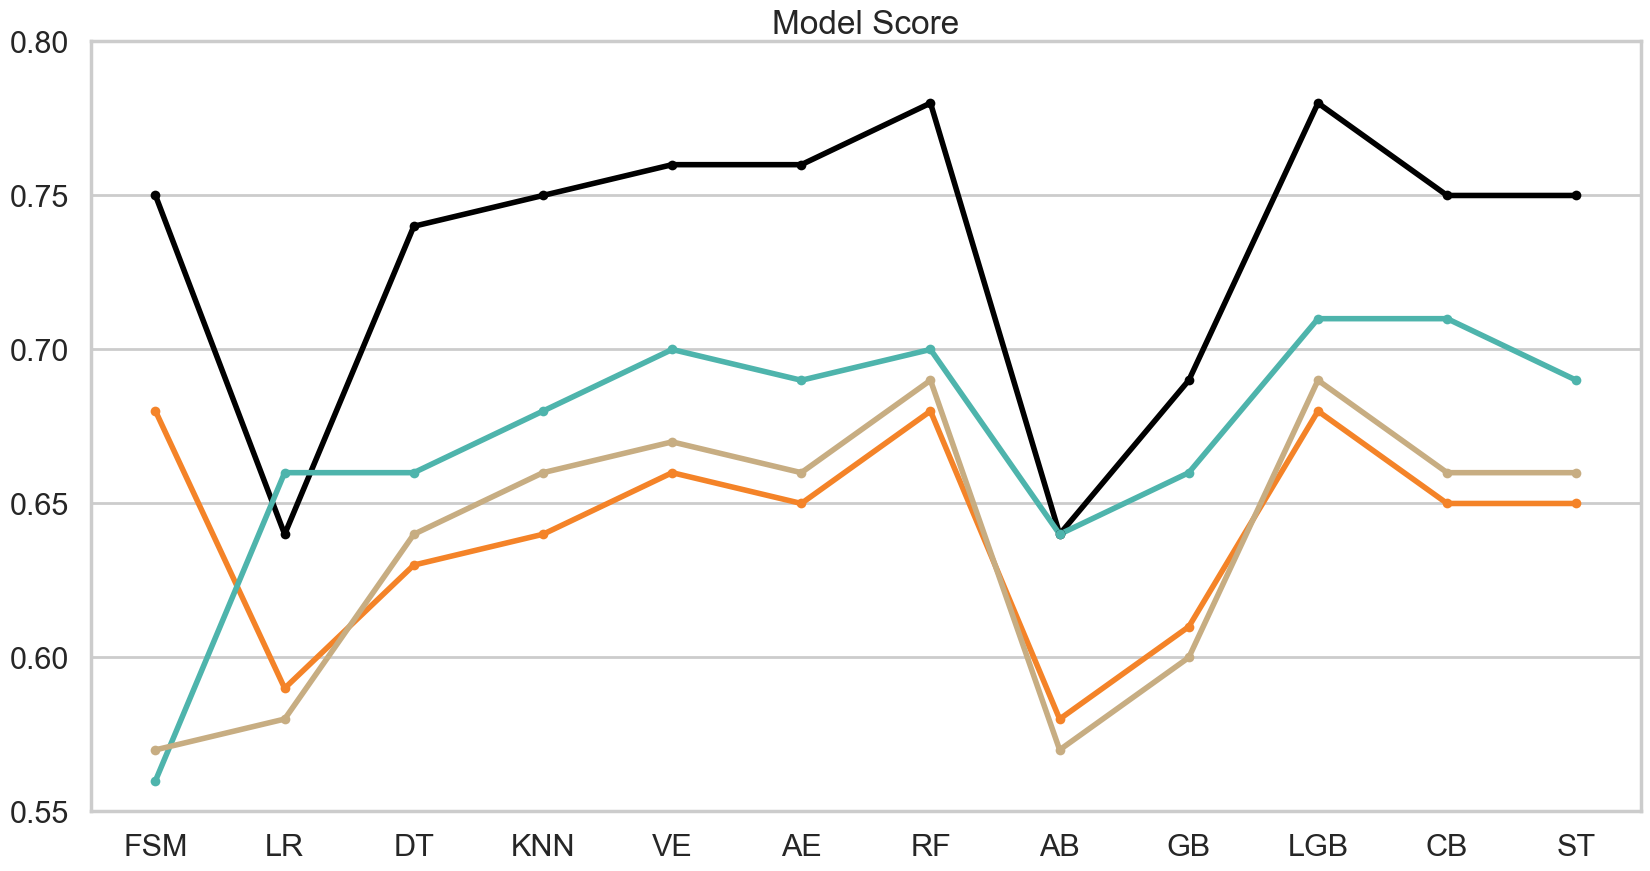

True

In [138]:
mf.plot_model_score(12)

# Final Predictions

Turns out our stacking ensemble didn't work as well as we'd hoped. We are going with the Light Gradient Boost model as our final model

#### Preprocess unlabeled data set

In [139]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')
unlabeled_df_geo = unlabeled_df[['longitude', 'latitude']]

# Drop the same columns as in our other data set
columns_with_na = ['permit', 'scheme_name', 'public_meeting', 'subvillage', 'installer', 'funder']
unlabeled_df.drop(columns_with_na, axis=1, inplace=True)
columns_with_specific_location_and_names = ['ward', 'wpt_name']
unlabeled_df.drop(columns_with_specific_location_and_names, axis=1, inplace=True)
unlabeled_df.drop('date_recorded', axis=1, inplace=True)

# Impute scheme_management 
unlabeled_df['scheme_management'] = unlabeled_df['scheme_management'].fillna("UNKNOWN")

In [140]:
# Call our function to preprocess our testing data
unlabeled_df = mf.preprocess_testing_data(unlabeled_df, si, ss, ohe)

In [141]:
# Reorder the columns so it matches our training dataset
unlabeled_df = unlabeled_df[X_train_filt.columns]

#### Make our final predictions

In [142]:
# Make our final predictions
y_pred = xgbc.predict(unlabeled_df)

### Plot our Final Predictions

Create a new data frame with locations and predictions of testing data

In [143]:
y_pred_df = pd.DataFrame(y_pred, index = unlabeled_df_geo.index)
final_df = pd.concat([unlabeled_df_geo, y_pred_df], axis=1)
final_df.head()

longitude   latitude               0
id                                         
50785  35.290799  -4.059696  non functional
51630  36.656709  -3.309214      functional
17168  34.767863  -5.004344      functional
45559  38.058046  -9.418672  non functional
49871  35.006123 -10.950412      functional

#### Convert our pandas DataFrame to a GeoDataFrame

In [144]:
# Add a geometry column that holds Point objects with lat and long
final_df['geometry'] = final_df.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
final_df = gpd.GeoDataFrame(final_df, geometry='geometry')
final_df.crs = "EPSG:4326"
final_df = final_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Make our GeoPandas Plot with our Final Predictions

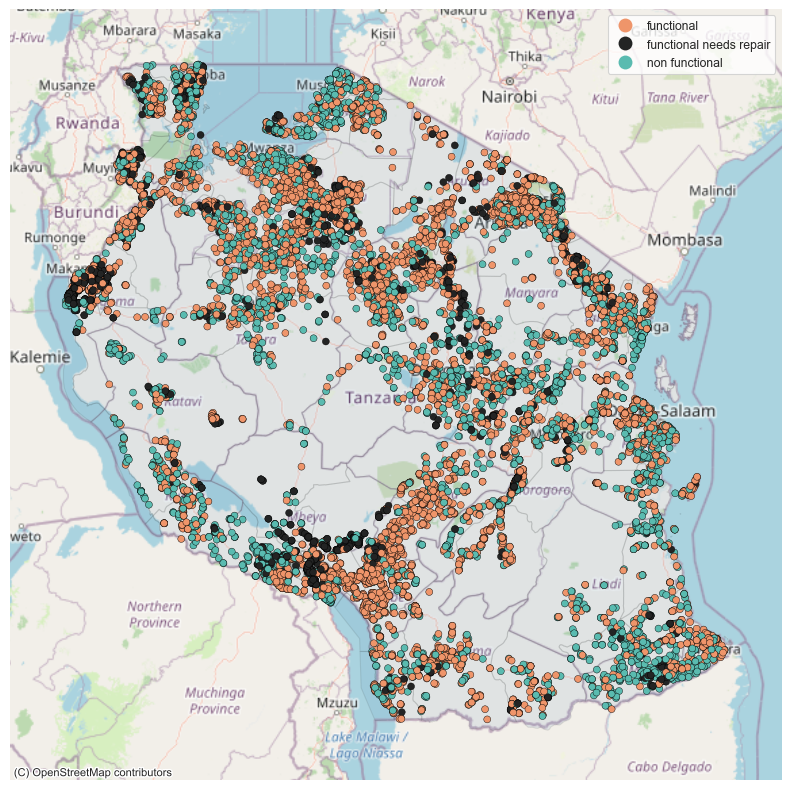

In [145]:
sns.set_context("paper", font_scale=1)
fig, ax = plt.subplots(figsize=(8,8))
geo_df.plot(ax=ax, color = 'steelblue', edgecolor = 'k', alpha = .1)

final_df.plot(ax=ax, column = 0, marker = '.', markersize=100,
         edgecolor = 'black', cmap = custom_palette,
         linewidth=.3, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-100000, maxx+100000)
ax.set_ylim(miny-100000, maxy+100000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Well Status Final Predictions', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_final.jpg');